# This Jupyter notebook reproduces the results reported by Bayona et al. (GJI, in review) on the prospective evaluation of RELM and multiplicative earthquake forecasting models for California

### Authors: Toño Bayona, Bill Savran and Pablito Iturrieta. 
### Last update: 2 December, 2021.

In [1]:
import os
import numpy as np
import scipy.stats
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import csep
from csep.core import regions
from csep.utils import time_utils, comcat
from csep.core import poisson_evaluations as poisson
from csep.utils import datasets, time_utils, plots
from matplotlib.lines import Line2D
from csep.core.forecasts import GriddedForecast, GriddedDataSet
from csep.utils.stats import poisson_joint_log_likelihood_ndarray
from scipy.stats import nbinom
import math
from csep.models import EvaluationResult
from cartopy.io import img_tiles
import numpy
import pickle

### Forecasts:

In [2]:
# California:
Bird = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/bird_liu.neokinema-fromXML.dat'
HKJ = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj.aftershock-fromXML.dat'
PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/holliday.pi-fromXML.dat'
HKJ_ALM = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_alm-fromXML.dat'
HKJ_Bird = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_neokinema-fromXML.dat'
HKJ_Bird_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_neokinema_pi-fromXML.dat'
HKJ_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_pi-fromXML.dat'
Ebel_c = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/ebel.aftershock.corrected-fromXML.dat'
HKJ_Ebel = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_ebel-fromXML.dat'

# southern California:
Kagan = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/kagan_et_al.aftershock-fromXML_c.dat'
Shen = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/shen_et_al.geodetic.aftershock-fromXML_c.dat'
HKJ_Kagan = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_kagan-fromXML_c.dat'   
HKJ_Bird_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_neokinema-fromXML_c.dat'
HKJ_PI_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_pi-fromXML_c.dat'
HKJ_Shen = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_shen-fromXML_c.dat'
HKJ_Shen_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_shen_pi-fromXML_c.dat'
HKJ_Ward_combo = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_combo-fromXML_c.dat'
HKJ_Ward_geol = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_geologic81-fromXML_c.dat'
HKJ_Ward_seis = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_seismic81-fromXML_c.dat'
HKJ_Ward_sim = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_simulation-fromXML_c.dat'
HKJ_Ward_geod81 = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_geodetic81-fromXML_c.dat'
HKJ_Ward_geod85 = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_geodetic85-fromXML_c.dat'

In [3]:
HKJ_HKJ_Kagan_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj_in_hkj_kagan.aftershock-fromXML_c2.dat'  #HKJ forecast grid scaled to fit the HKJ_Kagan forecasting area
HKJ_Shen_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj_in_shen.aftershock-fromXML_c2.dat' #HKJ forecast grid scaled to fit the Shen forecasting area
HKJ_Kagan_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj_in_kagan.aftershock-fromXML_c2.dat' #HKJ forecast grid scaled to fit the Kagan forecasting area
HKJ_Ward_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj_in_ward_combo.aftershock-fromXML_c2.dat'#HKJ forecast grid scaled to fit the Ward forecasting area

PI_in_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/holliday.pi_in_pi-fromXML_c2.dat' # PI forecast in PI region
HKJ_in_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj_in_pi.aftershock-fromXML_c2.dat'  # HKJ forecast in PI region

In [4]:
# California:
Bird = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/bird_liu.neokinema-fromXML.dat'
HKJ = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj.aftershock-fromXML.dat'
PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/holliday.pi-fromXML.dat'
HKJ_ALM = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_alm-fromXML.dat'
HKJ_Bird = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_neokinema-fromXML.dat'
HKJ_Bird_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_neokinema_pi-fromXML.dat'
HKJ_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_pi-fromXML.dat'
Ebel_c = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/ebel.aftershock.corrected-fromXML.dat'
HKJ_Ebel = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_mhyb_hkj_ebel-fromXML.dat'

# southern California:
Kagan = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/kagan_et_al.aftershock-fromXML_c.dat'
Shen = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/shen_et_al.geodetic.aftershock-fromXML_c.dat'
HKJ_Kagan = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj.aftershock-fromXML_HKJ_Kagan_sc.dat'
HKJ_Bird_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_neokinema-fromXML_c.dat'
HKJ_PI_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_pi-fromXML_c.dat'
HKJ_Shen = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_shen-fromXML_c.dat'
HKJ_Shen_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_shen_pi-fromXML_c.dat'
HKJ_Ward_combo = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_combo-fromXML_c.dat'
HKJ_Ward_geol = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_geologic81-fromXML_c.dat'
HKJ_Ward_seis = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_seismic81-fromXML_c.dat'
HKJ_Ward_sim = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_simulation-fromXML_c.dat'
HKJ_Ward_geod81 = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_geodetic81-fromXML_c.dat'
HKJ_Ward_geod85 = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_geodetic85-fromXML_c.dat'

In [5]:
HKJ_HKJ_Kagan_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj.aftershock-fromXML_HKJ_Kagan.dat'  #HKJ forecast grid scaled to fit the HKJ_Kagan forecasting area
HKJ_HKJ_PI_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/holliday.pi-fromXML_c2.dat' #HKJ forecast grid scaled to fit the PI forecasting area
HKJ_Shen_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_shen-fromXML_c2.dat' #HKJ forecast grid scaled to fit the Shen forecasting area
HKJ_Kagan_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_kagan-fromXML_c2.dat' #HKJ forecast grid scaled to fit the Kagan forecasting area
HKJ_Ward_sca = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/relm_scal_mhyb_hkj_ward_combo-fromXML_c2.dat'#HKJ forecast grid scaled to fit the Ward forecasting area

PI_in_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/holliday.pi-fromXML_in_PI.dat' # PI forecast in PI region
HKJ_in_PI = '/home/tono/Documents/Postdoc/1Paper/Forecasts/FORECASTS/helmstetter_et_al.hkj.aftershock-fromXML_in_PI.dat'  # HKJ forecast in PI region

In [6]:
start_date = time_utils.strptime_to_utc_datetime('2011-01-01 00:00:00.0')
end_date = time_utils.strptime_to_utc_datetime('2020-12-31 11:59:59.0')
duration = (end_date - start_date) # in days
duration =  round(duration.days / 365.25,2) # in years
ofp = 5.0 # original forecast period (in years)
factor = duration / ofp # scaling factor
seed = 123456

In [7]:
# Earthquake forecasts for California:
Bird_f = csep.load_gridded_forecast(Bird, start_date=start_date, end_date=end_date, name='BIRD').scale(factor)
HKJ_f = csep.load_gridded_forecast(HKJ, start_date=start_date, end_date=end_date, name='HKJ').scale(factor)
PI_f = csep.load_gridded_forecast(PI, start_date=start_date, end_date=end_date, name='PI').scale(factor)
HKJ_ALMf = csep.load_gridded_forecast(HKJ_ALM, start_date=start_date, end_date=end_date, name='HKJ-ALM').scale(factor)
HKJ_Birdf = csep.load_gridded_forecast(HKJ_Bird, start_date=start_date, end_date=end_date, name='HKJ-BIRD').scale(factor)
HKJ_Bird_PIf = csep.load_gridded_forecast(HKJ_Bird_PI, start_date=start_date, end_date=end_date, name='HKJ-BIRD-PI').scale(factor)
HKJ_PIf = csep.load_gridded_forecast(HKJ_PI, start_date=start_date, end_date=end_date, name='HKJ-PI').scale(factor)
Ebel_cf = csep.load_gridded_forecast(Ebel_c, start_date=start_date, end_date=end_date, name='EBEL-C').scale(factor)
HKJ_Ebelf = csep.load_gridded_forecast(HKJ_Ebel, start_date=start_date, end_date=end_date, name='HKJ-EBEL').scale(factor)

# Earthquake forecasts for southern California:
Kagan_f = csep.load_gridded_forecast(Kagan, start_date=start_date, end_date=end_date, name='KAGAN').scale(factor)
Shen_f = csep.load_gridded_forecast(Shen, start_date=start_date, end_date=end_date, name='SHEN').scale(factor)
HKJ_Kaganf = csep.load_gridded_forecast(HKJ_Kagan, start_date=start_date, end_date=end_date, name='HKJ-KAGAN').scale(factor)
HKJ_Bird_scaf = csep.load_gridded_forecast(HKJ_Bird_sca, start_date=start_date, end_date=end_date, name='HKJ-BIRD-SCA').scale(factor)
HKJ_PI_scaf = csep.load_gridded_forecast(HKJ_PI_sca, start_date=start_date, end_date=end_date, name='HKJ-PI-SCA').scale(factor)
HKJ_Shenf = csep.load_gridded_forecast(HKJ_Shen, start_date=start_date, end_date=end_date, name='HKJ-SHEN').scale(factor)
HKJ_Shen_PIf = csep.load_gridded_forecast(HKJ_Shen_PI, start_date=start_date, end_date=end_date, name='HKJ-SHEN-PI').scale(factor)
HKJ_Ward_combof = csep.load_gridded_forecast(HKJ_Ward_combo, start_date=start_date, end_date=end_date, name='HKJ-WARD-COMBO').scale(factor)
HKJ_Ward_geolf = csep.load_gridded_forecast(HKJ_Ward_geol, start_date=start_date, end_date=end_date, name='HKJ-WARD-GEOL').scale(factor)
HKJ_Ward_seisf = csep.load_gridded_forecast(HKJ_Ward_seis, start_date=start_date, end_date=end_date, name='HKJ-WARD-SEIS').scale(factor)
HKJ_Ward_simf = csep.load_gridded_forecast(HKJ_Ward_sim, start_date=start_date, end_date=end_date, name='HKJ-WARD-SIM').scale(factor)
HKJ_Ward_geod81f = csep.load_gridded_forecast(HKJ_Ward_geod81, start_date=start_date, end_date=end_date, name='HKJ-WARD-GEOD81').scale(factor)
HKJ_Ward_geod85f = csep.load_gridded_forecast(HKJ_Ward_geod85, start_date=start_date, end_date=end_date, name='HKJ-WARD-GEOD85').scale(factor)

In [8]:
HKJ_HKJ_Kaganf_sca = csep.load_gridded_forecast(HKJ_HKJ_Kagan_sca, start_date=start_date, end_date=end_date, name='HKJ').scale(factor)
HKJ_PIf_sca = csep.load_gridded_forecast(HKJ_PI_sca , start_date=start_date, end_date=end_date, name='HKJ').scale(factor)
HKJ_Shenf_sca = csep.load_gridded_forecast(HKJ_Shen_sca, start_date=start_date, end_date=end_date, name='HKJ').scale(factor)
HKJ_Kaganf_sca = csep.load_gridded_forecast(HKJ_Kagan_sca, start_date=start_date, end_date=end_date, name='HKJ').scale(factor)
HKJ_Wardf_sca = csep.load_gridded_forecast(HKJ_Ward_sca, start_date=start_date, end_date=end_date, name='HKJ').scale(factor)

PI_PIf = csep.load_gridded_forecast(PI_in_PI, start_date=start_date, end_date=end_date, name='PI').scale(factor)
HKJ_inPIf = csep.load_gridded_forecast(HKJ_in_PI, start_date=start_date, end_date=end_date, name='HKJ').scale(factor)

## Testing datasets:

In [ ]:
# Earthquake catalog with the CSEP-California testing region:
catalog_Cali1 = csep.query_comcat(Bird_f.start_time, Bird_f.end_time, min_magnitude = Bird_f.min_magnitude)

In [ ]:
with open('catalog_ANSS.obj', 'wb') as obj:
    pickle.dump(catalog_Cali1, obj)

In [9]:
with open('catalog_ANSS.obj', 'rb') as obj:
    cat = pickle.load(obj)

In [10]:
catalog_Cali2 = cat.filter_spatial(region=Bird_f.region, update_stats=False, in_place=True) # Bird region

In [11]:
with open('catalog_ANSS.obj', 'rb') as obj:
    cat = pickle.load(obj)

In [12]:
catalog_CaliP2 = cat.filter_spatial(region=PI_PIf.region, update_stats=False, in_place=True) # PI region

In [13]:
with open('catalog_ANSS.obj', 'rb') as obj:
    cat = pickle.load(obj)

In [14]:
catalog_Ebel = cat.filter_spatial(region=Ebel_cf.region, update_stats=False, in_place=True) # Ebel region

In [15]:
with open('catalog_ANSS.obj', 'rb') as obj:
    cat = pickle.load(obj)

In [16]:
catalog_Kagan = cat.filter_spatial(region=Kagan_f.region, update_stats=False, in_place=True) # Kagan region

In [17]:
with open('catalog_ANSS.obj', 'rb') as obj:
    cat = pickle.load(obj)

In [18]:
catalog_Kagan = cat.filter_spatial(region=Kagan_f.region, update_stats=False, in_place=True) # Kagan region

In [19]:
with open('catalog_ANSS.obj', 'rb') as obj:
    cat = pickle.load(obj)

In [20]:
catalog_HKJ_Kagan = cat.filter_spatial(region=HKJ_Kaganf.region, update_stats=False, in_place=True) # HKJ_Kagan region

In [21]:
with open('catalog_ANSS.obj', 'rb') as obj:
    cat = pickle.load(obj)

In [22]:
catalog_Shen= cat.filter_spatial(region=Shen_f.region, update_stats=False, in_place=True) # Shen region

In [23]:
with open('catalog_ANSS.obj', 'rb') as obj:
    cat = pickle.load(obj)

In [24]:
catalog_Ward= cat.filter_spatial(HKJ_Ward_combof.region, update_stats=False, in_place=True) # Ward region

## Forecast maps:

In [25]:
def _get_basemap(basemap):

    if basemap == 'stamen_terrain':
        tiles = img_tiles.Stamen('terrain')
    elif basemap == 'stamen_terrain-background':
        tiles = img_tiles.Stamen('terrain-background')
    elif basemap == 'google-satellite':
        tiles = img_tiles.GoogleTiles(style='satellite')
    elif basemap == 'ESRI_terrain':
        webservice = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Terrain_Base/' \
                 'MapServer/tile/{z}/{y}/{x}.jpg'
        tiles = img_tiles.GoogleTiles(url=webservice)
    elif basemap == 'ESRI_imagery':
        webservice = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/' \
                 'MapServer/tile/{z}/{y}/{x}.jpg'
        tiles = img_tiles.GoogleTiles(url=webservice)
    elif basemap == 'ESRI_relief':
        webservice = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/' \
                 'MapServer/tile/{z}/{y}/{x}.jpg'
        tiles = img_tiles.GoogleTiles(url=webservice)
    elif basemap == 'ESRI_topo':
        webservice = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/' \
                 'MapServer/tile/{z}/{y}/{x}.jpg'
        tiles = img_tiles.GoogleTiles(url=webservice)
    else:
        raise ValueError('Basemap type not valid or not implemented')

    return tiles

/home/tono/anaconda3/envs/gji-hybrids/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/tono/anaconda3/envs/gji-hybrids/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/tono/anaconda3/envs/gji-hybrids/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/tono/anaconda3/envs/gji-hybrids/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .l

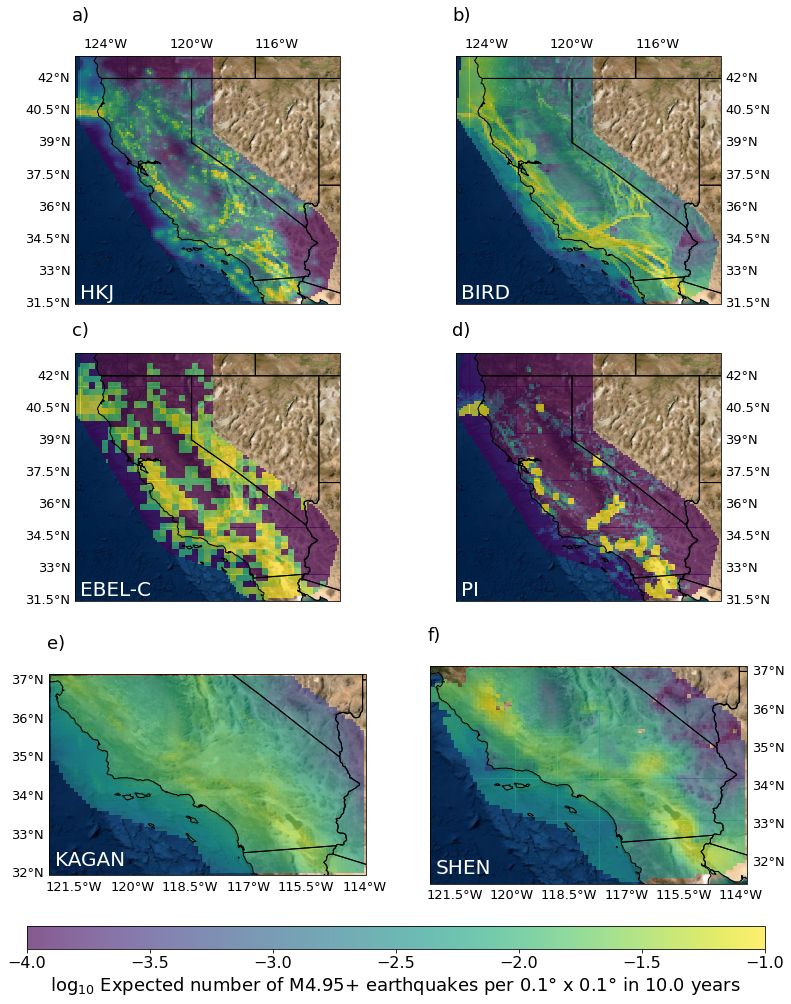

In [26]:
fig = plt.figure(figsize=(12.5,15.5))
ax_HKJ = fig.add_subplot(321, projection=ccrs.PlateCarree())
ax_HKJ.add_feature(cartopy.feature.STATES)
ax_HKJ.add_image(_get_basemap('ESRI_imagery'), 6)
dh = round(HKJ_f.region.dh, 5)
gl = ax_HKJ.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = True 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_HKJ.set_xlim(min(HKJ_f.get_longitudes())-0.1+dh/2, max(HKJ_f.get_longitudes())+0.1+dh/2)
ax_HKJ.set_ylim(min(HKJ_f.get_latitudes())-0.1+dh/2, max(HKJ_f.get_latitudes())+0.1+dh/2)
ax_HKJ.text(min(HKJ_f.get_longitudes()) -0.2, max(HKJ_f.get_latitudes())+1.8, 'a)', fontsize =18, color='black')
ax_HKJ.text(min(HKJ_f.get_longitudes())+0.2, min(HKJ_f.get_latitudes())+0.2, f'{HKJ_f.name}', fontsize=20, color='white')
    
scatter = ax_HKJ.scatter(HKJ_f.get_longitudes() + dh/2, HKJ_f.get_latitudes() + dh/2, 
                        c = np.log10(HKJ_f.spatial_counts()), cmap='viridis', marker='s',
                            s=4.7, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)
    
    
ax_Bird = fig.add_subplot(322, projection=ccrs.PlateCarree())
ax_Bird.add_feature(cartopy.feature.STATES)
ax_Bird.add_image(_get_basemap('ESRI_imagery'), 6)
gl = ax_Bird.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = True 
gl.xlabels_bottom = False 
gl.ylabels_right = True
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_Bird.set_xlim(min(Bird_f.get_longitudes())-0.1+dh/2, max(Bird_f.get_longitudes())+0.1+dh/2)
ax_Bird.set_ylim(min(Bird_f.get_latitudes())-0.1+dh/2, max(Bird_f.get_latitudes())+0.1+dh/2)
ax_Bird.text(min(Bird_f.get_longitudes()) -0.2, max(Bird_f.get_latitudes())+1.8, 'b)', fontsize =18, color='black')
ax_Bird.text(min(Bird_f.get_longitudes())+0.2, min(Bird_f.get_latitudes())+0.2, f'{Bird_f.name}', fontsize=20, color='white')


    
scatter = ax_Bird.scatter(Bird_f.get_longitudes() + dh/2, Bird_f.get_latitudes() + dh/2, 
                        c = np.log10(Bird_f.spatial_counts()), cmap='viridis', marker='s',
                            s=4.7, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)
    
  

    
ax_Ebel = fig.add_subplot(323, projection=ccrs.PlateCarree())
ax_Ebel.add_feature(cartopy.feature.STATES)
ax_Ebel.add_image(_get_basemap('ESRI_imagery'), 6)
gl = ax_Ebel.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_Ebel.set_xlim(min(Ebel_cf.get_longitudes())-0.1+dh/2, max(Ebel_cf.get_longitudes())+0.1+dh/2)
ax_Ebel.set_ylim(min(Ebel_cf.get_latitudes())-0.1+dh/2, max(Ebel_cf.get_latitudes())+0.1+dh/2)
ax_Ebel.text(min(Ebel_cf.get_longitudes()) -0.2, max(Ebel_cf.get_latitudes())+1, 'c)', fontsize =18, color='black')

ax_Ebel.text(min(Ebel_cf.get_longitudes())+0.2, min(Ebel_cf.get_latitudes())+0.2, f'{Ebel_cf.name}', fontsize=20, color='white')


scatter = ax_Ebel.scatter(Ebel_cf.get_longitudes() + dh/2, Ebel_cf.get_latitudes() + dh/2, 
                        c = np.log10(Ebel_cf.spatial_counts()), cmap='viridis',  marker='s',
                            s=4.7, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)



ax_PI = fig.add_subplot(324, projection=ccrs.PlateCarree())
ax_PI.add_feature(cartopy.feature.STATES)
ax_PI.add_image(_get_basemap('ESRI_imagery'), 6)
ax_PI.set_facecolor('lightgrey')
gl = ax_PI.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = True
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_PI.set_xlim(min(PI_f.get_longitudes())-0.1+dh/2, max(PI_f.get_longitudes())+0.1+dh/2)
ax_PI.set_ylim(min(PI_f.get_latitudes())-0.1+dh/2, max(PI_f.get_latitudes())+0.1+dh/2)
ax_PI.text(min(PI_f.get_longitudes()) -0.2, max(PI_f.get_latitudes())+1, 'd)', fontsize =18, color='black')

ax_PI.text(min(PI_f.get_longitudes())+0.2, min(PI_f.get_latitudes())+0.2, f'{PI_f.name}', fontsize=20, color='white')


scatter = ax_PI.scatter(PI_f.get_longitudes() + dh/2, PI_f.get_latitudes() + dh/2, 
                        c = np.log10(PI_f.spatial_counts()), cmap='viridis', marker='s',
                            s=4.7, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)
    
    
ax_Kagan = fig.add_subplot(325, projection=ccrs.PlateCarree())
ax_Kagan.add_feature(cartopy.feature.STATES)
ax_Kagan.add_image(_get_basemap('ESRI_imagery'), 6)
gl = ax_Kagan.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = True 
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_Kagan.set_xlim(min(Kagan_f.get_longitudes())-0.1+dh/2, max(Kagan_f.get_longitudes())+0.1+dh/2)
ax_Kagan.set_ylim(min(Kagan_f.get_latitudes())-0.1+dh/2, max(Kagan_f.get_latitudes())+0.1+dh/2)
ax_Kagan.text(min(Kagan_f.get_longitudes()) -0.1, max(Kagan_f.get_latitudes())+0.8, 'e)', fontsize =18, color='black')
ax_Kagan.text(min(Kagan_f.get_longitudes())+0.1, min(Kagan_f.get_latitudes())+0.2, f'{Kagan_f.name}', fontsize=20, color='white')


scatter = ax_Kagan.scatter(Kagan_f.get_longitudes()+ dh/2, Kagan_f.get_latitudes() + dh/2, 
                        c = np.log10(Kagan_f.spatial_counts()), cmap='viridis', marker='s',
                            s=15, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1) 


ax_Shen = fig.add_subplot(326, projection=ccrs.PlateCarree())
ax_Shen.add_feature(cartopy.feature.STATES)
ax_Shen.add_image(_get_basemap('ESRI_imagery'), 6)
gl = ax_Shen.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = True 
gl.ylabels_right = True
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_Shen.set_xlim(min(Shen_f.get_longitudes())-0.1+dh/2, max(Shen_f.get_longitudes())+0.1+dh/2)
ax_Shen.set_ylim(min(Shen_f.get_latitudes())-0.1+dh/2, max(Shen_f.get_latitudes())+0.1+dh/2)
ax_Shen.text(min(Shen_f.get_longitudes()) -0.1, max(Shen_f.get_latitudes())+0.8, 'f)', fontsize =18, color='black')
ax_Shen.text(min(Shen_f.get_longitudes())+0.1, min(Shen_f.get_latitudes())+0.2, f'{Shen_f.name}', fontsize=20, color='white')

    
scatter = ax_Shen.scatter(Shen_f.get_longitudes()+ dh/2, Shen_f.get_latitudes() + dh/2, 
                        c = np.log10(Shen_f.spatial_counts()), cmap='viridis',marker='s',
                            s=15, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)  

cax = fig.add_axes([0.1, 0.08, 0.82, 0.02]) 
cbar = plt.colorbar(scatter, cax = cax, orientation="horizontal")  
cbar.set_label('log$_{10}$ Expected number of M'f'{HKJ_Ward_simf.min_magnitude}+ earthquakes per ' f'{str(dh)}° x {str(dh)}° in 'f'{duration} years', fontsize=18)# cbar.ax.tick_params(labelsize=20)  
cbar.ax.tick_params(labelsize=16)
plt.savefig('Fig1.png', dpi=200, bbox_inches = 'tight')

#### Fig. 1: Original RELM models submitted to the mainshock+aftershock class of CSEP: a) HKJ, b) BIRD, c)EBEL-C, d) PI, e) KAGAN, f) SHEN. Expected number of M$\geq$4.95 earthquakes are shown per 0.1$^{\circ} \times$ 0.1$^{\circ}$ unit area per decade.

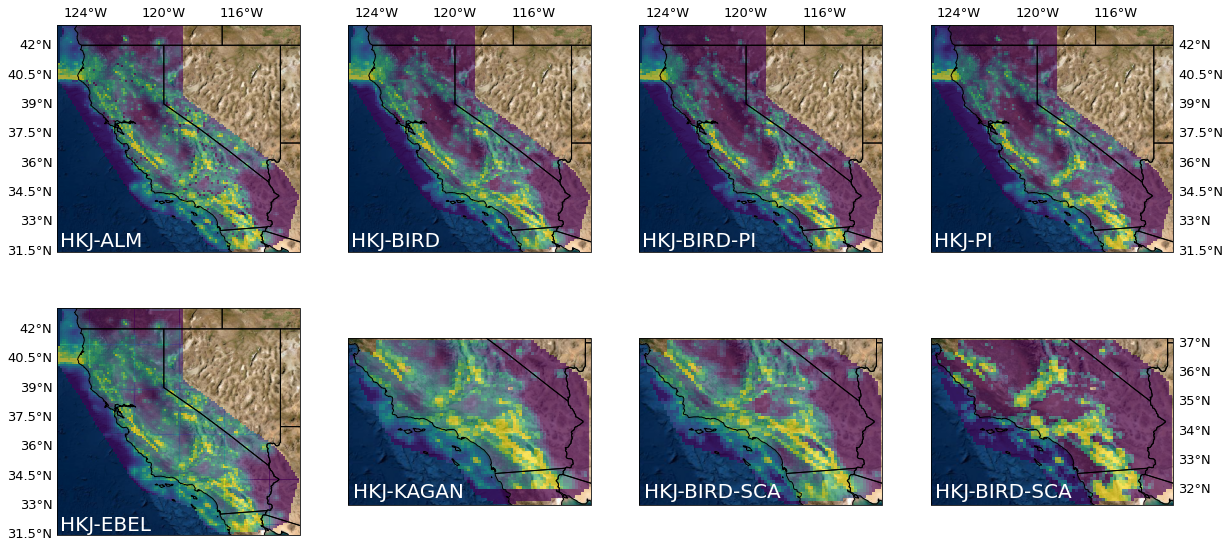

In [27]:
fig = plt.figure(figsize=(20,20))
ax_HKJ_ALM = fig.add_subplot(441, projection=ccrs.PlateCarree())
ax_HKJ_ALM.add_feature(cartopy.feature.STATES)
ax_HKJ_ALM.add_image(_get_basemap('ESRI_imagery'), 6)
dh = round(HKJ_f.region.dh, 5)
gl = ax_HKJ_ALM.gridlines()
gl.xlines = False
gl.ylines = False
gl.xlabels_top = True 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_HKJ_ALM.set_xlim(min(HKJ_ALMf.get_longitudes())-0.1+dh/2, max(HKJ_ALMf.get_longitudes())+0.1+dh/2)
ax_HKJ_ALM.set_ylim(min(HKJ_ALMf.get_latitudes())-0.1+dh/2, max(HKJ_ALMf.get_latitudes())+0.1+dh/2)
ax_HKJ_ALM.text(min(HKJ_ALMf.get_longitudes())+0.1, min(HKJ_ALMf.get_latitudes())+0.2, f'{HKJ_ALMf.name}', fontsize=20, color='white')
    
scatter = ax_HKJ_ALM.scatter(HKJ_ALMf.get_longitudes()+dh/2, HKJ_ALMf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_ALMf.spatial_counts()), cmap='viridis', s=3.8, vmax=-1, vmin=-4, marker='s',
                            alpha =0.65, edgecolor="None", zorder=1)
        
ax_HKJ_Bird = fig.add_subplot(442, projection=ccrs.PlateCarree())
ax_HKJ_Bird.add_feature(cartopy.feature.STATES)
ax_HKJ_Bird.add_image(_get_basemap('ESRI_imagery'), 6)
gl = ax_HKJ_Bird.gridlines()
gl.xlines = False
gl.ylines = False
gl.xlabels_top = True 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 0}

ax_HKJ_Bird.set_xlim(min(HKJ_Birdf.get_longitudes())-0.1+dh/2, max(HKJ_Birdf.get_longitudes())+0.1+dh/2)
ax_HKJ_Bird.set_ylim(min(HKJ_Birdf.get_latitudes())-0.1+dh/2, max(HKJ_Birdf.get_latitudes())+0.1+dh/2)
ax_HKJ_Bird.text(min(HKJ_Birdf.get_longitudes())+0.1, min(HKJ_Birdf.get_latitudes())+0.2, f'{HKJ_Birdf.name}', fontsize=20, color='white')


scatter = ax_HKJ_Bird.scatter(HKJ_Birdf.get_longitudes() + dh/2, HKJ_Birdf.get_latitudes() + dh/2, 
                        c = np.log10(HKJ_Birdf.spatial_counts()), cmap='viridis', s=3.8, vmax=-1, vmin=-4, marker='s',
                             alpha =0.65, edgecolor="None", zorder=1)
    
    
ax_HKJ_Bird_PI = fig.add_subplot(443, projection=ccrs.PlateCarree())
ax_HKJ_Bird_PI.add_feature(cartopy.feature.STATES)
ax_HKJ_Bird_PI.add_image(_get_basemap('ESRI_imagery'), 6)
gl = ax_HKJ_Bird_PI.gridlines()
gl.xlines = False
gl.ylines = False
gl.xlabels_top = True 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 0}

ax_HKJ_Bird_PI.set_xlim(min(HKJ_Bird_PIf.get_longitudes())-0.1+dh/2, max(HKJ_Bird_PIf.get_longitudes())+0.1+dh/2)
ax_HKJ_Bird_PI.set_ylim(min(HKJ_Bird_PIf.get_latitudes())-0.1+dh/2, max(HKJ_Bird_PIf.get_latitudes())+0.1+dh/2)
ax_HKJ_Bird_PI.text(min(HKJ_Bird_PIf.get_longitudes())+0.1, min(HKJ_Bird_PIf.get_latitudes())+0.2, f'{HKJ_Bird_PIf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_Bird_PI.scatter(HKJ_Bird_PIf.get_longitudes() + dh/2, HKJ_Bird_PIf.get_latitudes() + dh/2, 
                        c = np.log10(HKJ_Bird_PIf.spatial_counts()), cmap='viridis', s=3.8, vmax=-1, vmin=-4, marker='s',
                                alpha =0.65, edgecolor="None", zorder=1)
    

    
ax_HKJ_PI = fig.add_subplot(444, projection=ccrs.PlateCarree())
ax_HKJ_PI.add_feature(cartopy.feature.STATES)
ax_HKJ_PI.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_PI.set_facecolor('lightgrey')
gl = ax_HKJ_PI.gridlines()
gl.xlines = False
gl.ylines = False
gl.xlabels_top = True 
gl.xlabels_bottom = False 
gl.ylabels_right = True
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_HKJ_PI.set_xlim(min(HKJ_PIf.get_longitudes())-0.1+dh/2, max(HKJ_PIf.get_longitudes())+0.1+dh/2)
ax_HKJ_PI.set_ylim(min(HKJ_PIf.get_latitudes())-0.1+dh/2, max(HKJ_PIf.get_latitudes())+0.1+dh/2)
ax_HKJ_PI.text(min(HKJ_PIf.get_longitudes())+0.1, min(HKJ_PIf.get_latitudes())+0.2, f'{HKJ_PIf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_PI.scatter(HKJ_PIf.get_longitudes()+dh/2, HKJ_PIf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_PIf.spatial_counts()), cmap='viridis', s=3.8, vmax=-1, vmin=-4, marker='s',
                           alpha =0.65, edgecolor="None", zorder=1)
    

    
ax_HKJ_Ebel = fig.add_subplot(445, projection=ccrs.PlateCarree())
ax_HKJ_Ebel.add_feature(cartopy.feature.STATES)
ax_HKJ_Ebel.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_Ebel.set_facecolor('lightgrey')
gl = ax_HKJ_Ebel.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_HKJ_Ebel.set_xlim(min(HKJ_Ebelf.get_longitudes())-0.1+dh/2, max(HKJ_Ebelf.get_longitudes())+0.1+dh/2)
ax_HKJ_Ebel.set_ylim(min(HKJ_Ebelf.get_latitudes())-0.1+dh/2, max(HKJ_Ebelf.get_latitudes())+0.1+dh/2)
ax_HKJ_Ebel.text(min(HKJ_Ebelf.get_longitudes())+0.1, min(HKJ_Ebelf.get_latitudes())+0.2, f'{HKJ_Ebelf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_Ebel.scatter(HKJ_Ebelf.get_longitudes()+dh/2, HKJ_Ebelf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Ebelf.spatial_counts()), cmap='viridis', s=4, vmax=-1, vmin=-4, marker='s',
                              alpha =0.65, edgecolor="None", zorder=1)

    
ax_HKJ_Kagan = fig.add_subplot(446, projection=ccrs.PlateCarree())
ax_HKJ_Kagan.add_feature(cartopy.feature.STATES)
ax_HKJ_Kagan.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_Kagan.set_facecolor('lightgrey')
gl = ax_HKJ_Kagan.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 0}

ax_HKJ_Kagan.set_xlim(min(HKJ_Kaganf.get_longitudes())-0.1+dh/2, max(HKJ_Kaganf.get_longitudes())+0.1+dh/2)
ax_HKJ_Kagan.set_ylim(min(HKJ_Kaganf.get_latitudes())-0.1+dh/2, max(HKJ_Kaganf.get_latitudes())+0.1+dh/2)
ax_HKJ_Kagan.text(min(HKJ_Kaganf.get_longitudes())+0.1, min(HKJ_Kaganf.get_latitudes())+0.2, f'{HKJ_Kaganf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_Kagan.scatter(HKJ_Kaganf.get_longitudes()+dh/2, HKJ_Kaganf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Kaganf.spatial_counts()), cmap='viridis', s=8.6, vmax=-1, vmin=-4, marker='s',
                              alpha =0.65, edgecolor="None", zorder=1)
    

    
ax_HKJ_Bird_sca = fig.add_subplot(447, projection=ccrs.PlateCarree())
ax_HKJ_Bird_sca.add_feature(cartopy.feature.STATES)
ax_HKJ_Bird_sca.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_Bird_sca.set_facecolor('lightgrey')
gl = ax_HKJ_Bird_sca.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 0}

ax_HKJ_Bird_sca.set_xlim(min(HKJ_Bird_scaf.get_longitudes())-0.1+dh/2, max(HKJ_Bird_scaf.get_longitudes())+0.1+dh/2)
ax_HKJ_Bird_sca.set_ylim(min(HKJ_Bird_scaf.get_latitudes())-0.1+dh/2, max(HKJ_Bird_scaf.get_latitudes())+0.1+dh/2)
ax_HKJ_Bird_sca.text(min(HKJ_Bird_scaf.get_longitudes())+0.1, min(HKJ_Bird_scaf.get_latitudes())+0.2, f'{HKJ_Bird_scaf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_Bird_sca.scatter(HKJ_Bird_scaf.get_longitudes()+dh/2, HKJ_Bird_scaf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Bird_scaf.spatial_counts()), cmap='viridis', s=8.6, vmax=-1, vmin=-4, marker='s',
                              alpha =0.65, edgecolor="None", zorder=1)


ax_HKJ_PI_sca = fig.add_subplot(448, projection=ccrs.PlateCarree())
ax_HKJ_PI_sca.add_feature(cartopy.feature.STATES)
ax_HKJ_PI_sca.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_PI_sca.set_facecolor('lightgrey')
gl = ax_HKJ_PI_sca.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = True
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_HKJ_PI_sca.set_xlim(min(HKJ_PI_scaf.get_longitudes())-0.1+dh/2, max(HKJ_PI_scaf.get_longitudes())+0.1+dh/2)
ax_HKJ_PI_sca.set_ylim(min(HKJ_PI_scaf.get_latitudes())-0.1+dh/2, max(HKJ_PI_scaf.get_latitudes())+0.1+dh/2)
ax_HKJ_PI_sca.text(min(HKJ_PI_scaf.get_longitudes())+0.1, min(HKJ_PI_scaf.get_latitudes())+0.2, f'{HKJ_Bird_scaf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_PI_sca.scatter(HKJ_PI_scaf.get_longitudes()+dh/2, HKJ_PI_scaf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_PI_scaf.spatial_counts()), cmap='viridis', s=8.6, vmax=-1, vmin=-4, marker='s',
                              alpha =0.65, edgecolor="None", zorder=1)

plt.savefig('Fig2_top.png', dpi=100, bbox_inches = 'tight')

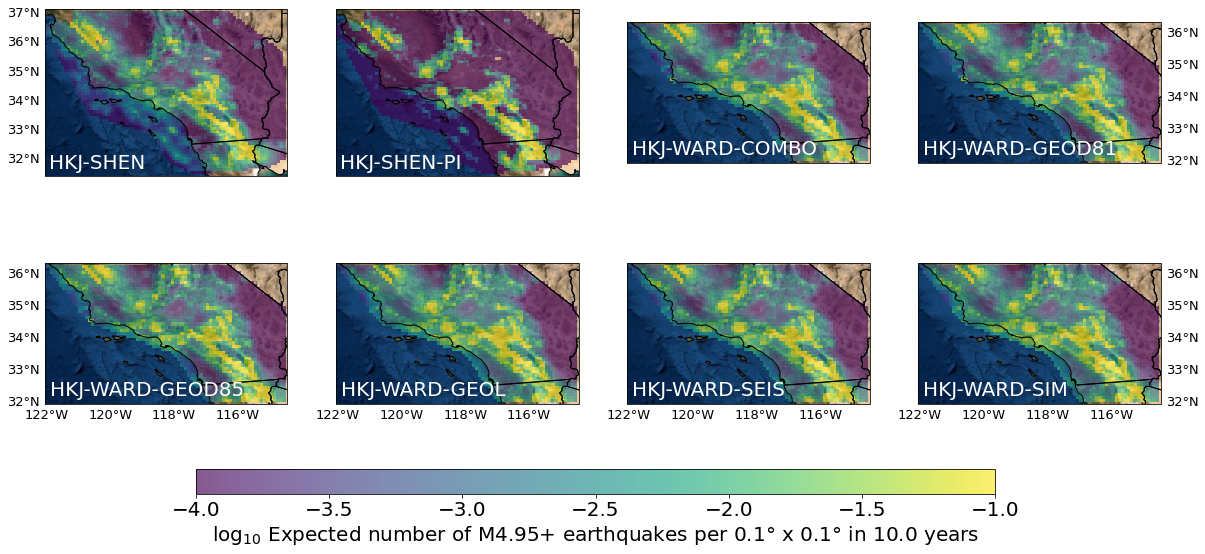

In [28]:
fig = plt.figure(figsize=(20,17))
dh = round(HKJ_f.region.dh, 5)
ax_HKJ_Shen = fig.add_subplot(441, projection=ccrs.PlateCarree())
ax_HKJ_Shen.add_feature(cartopy.feature.STATES)
ax_HKJ_Shen.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_Shen.set_facecolor('lightgrey')
gl = ax_HKJ_Shen.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlabel_style = {'size': 0}
gl.ylabel_style = {'size': 13}

ax_HKJ_Shen.set_xlim(min(HKJ_Shenf.get_longitudes())-0.1+dh/2, max(HKJ_Shenf.get_longitudes())+0.1+dh/2)
ax_HKJ_Shen.set_ylim(min(HKJ_Shenf.get_latitudes())-0.1+dh/2, max(HKJ_Shenf.get_latitudes())+0.1+dh/2)
ax_HKJ_Shen.text(min(HKJ_Shenf.get_longitudes())+0.1, min(HKJ_Shenf.get_latitudes())+0.2, f'{HKJ_Shenf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_Shen.scatter(HKJ_Shenf.get_longitudes()+dh/2, HKJ_Shenf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Shenf.spatial_counts()), cmap='viridis', marker='s',
                            s=8.6, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)

ax_HKJ_Shen_PI = fig.add_subplot(442, projection=ccrs.PlateCarree())
ax_HKJ_Shen_PI.add_feature(cartopy.feature.STATES)
ax_HKJ_Shen_PI.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_Shen_PI.set_facecolor('lightgrey')
gl = ax_HKJ_Shen_PI.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 0}
gl.ylabel_style = {'size': 0}

ax_HKJ_Shen_PI.set_xlim(min(HKJ_Shen_PIf.get_longitudes())-0.1+dh/2, max(HKJ_Shen_PIf.get_longitudes())+0.1+dh/2)
ax_HKJ_Shen_PI.set_ylim(min(HKJ_Shen_PIf.get_latitudes())-0.1+dh/2, max(HKJ_Shen_PIf.get_latitudes())+0.1+dh/2)
ax_HKJ_Shen_PI.text(min(HKJ_Shen_PIf.get_longitudes())+0.1, min(HKJ_Shen_PIf.get_latitudes())+0.2, f'{HKJ_Shen_PIf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_Shen_PI.scatter(HKJ_Shen_PIf.get_longitudes()+dh/2, HKJ_Shen_PIf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Shen_PIf.spatial_counts()), cmap='viridis', marker='s',
                            s=8.6, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)

ax_HKJ_W_combo = fig.add_subplot(443, projection=ccrs.PlateCarree())
ax_HKJ_W_combo.add_feature(cartopy.feature.STATES)
ax_HKJ_W_combo.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_W_combo.set_facecolor('lightgrey')
gl = ax_HKJ_W_combo.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 0}
gl.ylabel_style = {'size': 0}

ax_HKJ_W_combo.set_xlim(min(HKJ_Ward_combof.get_longitudes())-0.1+dh/2, max(HKJ_Ward_combof.get_longitudes())+0.1+dh/2)
ax_HKJ_W_combo.set_ylim(min(HKJ_Ward_combof.get_latitudes())-0.1+dh/2, max(HKJ_Ward_combof.get_latitudes())+0.1+dh/2)
ax_HKJ_W_combo.text(min(HKJ_Ward_combof.get_longitudes())+0.1, min(HKJ_Ward_combof.get_latitudes())+0.2, f'{HKJ_Ward_combof.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_W_combo.scatter(HKJ_Ward_combof.get_longitudes()+dh/2, HKJ_Ward_combof.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Ward_combof.spatial_counts()), cmap='viridis', marker='s',
                            s=10.2, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)

ax_HKJ_W_g81 = fig.add_subplot(444, projection=ccrs.PlateCarree())
ax_HKJ_W_g81.add_feature(cartopy.feature.STATES)
ax_HKJ_W_g81.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_W_g81.set_facecolor('lightgrey')
gl = ax_HKJ_W_g81.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = False 
gl.ylabels_right = True
gl.ylabels_left = False
gl.xlabel_style = {'size': 0}
gl.ylabel_style = {'size': 13}

ax_HKJ_W_g81.set_xlim(min(HKJ_Ward_geod81f.get_longitudes())-0.1+dh/2, max(HKJ_Ward_geod81f.get_longitudes())+0.1+dh/2)
ax_HKJ_W_g81.set_ylim(min(HKJ_Ward_geod81f.get_latitudes())-0.1+dh/2, max(HKJ_Ward_geod81f.get_latitudes())+0.1+dh/2)
ax_HKJ_W_g81.text(min(HKJ_Ward_geod81f.get_longitudes())+0.1, min(HKJ_Ward_geod81f.get_latitudes())+0.2, f'{HKJ_Ward_geod81f.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_W_g81.scatter(HKJ_Ward_geod81f.get_longitudes()+dh/2, HKJ_Ward_geod81f.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Ward_geod81f.spatial_counts()), cmap='viridis', marker='s',
                            s=10.2, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)


ax_HKJ_W_g85 = fig.add_subplot(445, projection=ccrs.PlateCarree())
ax_HKJ_W_g85.add_feature(cartopy.feature.STATES)
ax_HKJ_W_g85.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_W_g85.set_facecolor('lightgrey')
gl = ax_HKJ_W_g85.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = True 
gl.ylabels_right = False
gl.ylabels_left = True
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_HKJ_W_g85.set_xlim(min(HKJ_Ward_geod85f.get_longitudes())-0.1+dh/2, max(HKJ_Ward_geod85f.get_longitudes())+0.1+dh/2)
ax_HKJ_W_g85.set_ylim(min(HKJ_Ward_geod85f.get_latitudes())-0.1+dh/2, max(HKJ_Ward_geod85f.get_latitudes())+0.1+dh/2)
ax_HKJ_W_g85.text(min(HKJ_Ward_geod85f.get_longitudes())+0.1, min(HKJ_Ward_geod85f.get_latitudes())+0.2, f'{HKJ_Ward_geod85f.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_W_g85.scatter(HKJ_Ward_geod85f.get_longitudes()+dh/2, HKJ_Ward_geod85f.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Ward_geod85f.spatial_counts()), cmap='viridis', marker='s',
                            s=10.2, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)


ax_HKJ_W_geol = fig.add_subplot(446, projection=ccrs.PlateCarree())
ax_HKJ_W_geol.add_feature(cartopy.feature.STATES)
ax_HKJ_W_geol.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_W_geol.set_facecolor('lightgrey')
gl = ax_HKJ_W_geol.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = True 
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 0}

ax_HKJ_W_geol.set_xlim(min(HKJ_Ward_geolf.get_longitudes())-0.1+dh/2, max(HKJ_Ward_geolf.get_longitudes())+0.1+dh/2)
ax_HKJ_W_geol.set_ylim(min(HKJ_Ward_geolf.get_latitudes())-0.1+dh/2, max(HKJ_Ward_geolf.get_latitudes())+0.1+dh/2)
ax_HKJ_W_geol.text(min(HKJ_Ward_geolf.get_longitudes())+0.1, min(HKJ_Ward_geolf.get_latitudes())+0.2, f'{HKJ_Ward_geolf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_W_geol.scatter(HKJ_Ward_geolf.get_longitudes()+dh/2, HKJ_Ward_geolf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Ward_geolf.spatial_counts()), cmap='viridis', marker='s',
                            s=10.2, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)


ax_HKJ_W_seis = fig.add_subplot(447, projection=ccrs.PlateCarree())
ax_HKJ_W_seis.add_feature(cartopy.feature.STATES)
ax_HKJ_W_seis.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_W_seis.set_facecolor('lightgrey')
gl = ax_HKJ_W_seis.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = True 
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 0}

ax_HKJ_W_seis.set_xlim(min(HKJ_Ward_seisf.get_longitudes())-0.1+dh/2, max(HKJ_Ward_seisf.get_longitudes())+0.1+dh/2)
ax_HKJ_W_seis.set_ylim(min(HKJ_Ward_seisf.get_latitudes())-0.1+dh/2, max(HKJ_Ward_seisf.get_latitudes())+0.1+dh/2)
ax_HKJ_W_seis.text(min(HKJ_Ward_seisf.get_longitudes())+0.1, min(HKJ_Ward_seisf.get_latitudes())+0.2, f'{HKJ_Ward_seisf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_W_seis.scatter(HKJ_Ward_seisf.get_longitudes()+dh/2, HKJ_Ward_seisf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Ward_seisf.spatial_counts()), cmap='viridis', marker='s',
                            s=10.2, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)


ax_HKJ_W_sim = fig.add_subplot(448, projection=ccrs.PlateCarree())
ax_HKJ_W_sim.add_feature(cartopy.feature.STATES)
ax_HKJ_W_sim.add_image(_get_basemap('ESRI_imagery'), 6)
ax_HKJ_W_sim.set_facecolor('lightgrey')
gl = ax_HKJ_W_sim.gridlines(draw_labels=True, alpha=1, color='white')
gl.xlines = False
gl.ylines = False
gl.xlabels_top = False 
gl.xlabels_bottom = True 
gl.ylabels_right = True
gl.ylabels_left = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax_HKJ_W_sim.set_xlim(min(HKJ_Ward_simf.get_longitudes())-0.1+dh/2, max(HKJ_Ward_simf.get_longitudes())+0.1+dh/2)
ax_HKJ_W_sim.set_ylim(min(HKJ_Ward_simf.get_latitudes())-0.1+dh/2, max(HKJ_Ward_simf.get_latitudes())+0.1+dh/2)
ax_HKJ_W_sim.text(min(HKJ_Ward_simf.get_longitudes())+0.1, min(HKJ_Ward_simf.get_latitudes())+0.2, f'{HKJ_Ward_simf.name}', fontsize=20, color='white')

    
scatter = ax_HKJ_W_sim.scatter(HKJ_Ward_simf.get_longitudes()+dh/2, HKJ_Ward_simf.get_latitudes()+dh/2, 
                        c = np.log10(HKJ_Ward_simf.spatial_counts()), cmap='viridis', marker='s',
                            s=10.2, vmax=-1, vmin=-4,alpha =0.65, edgecolor="None", zorder=1)


cax = fig.add_axes([0.23, 0.47, 0.555, 0.02]) 
cbar = plt.colorbar(scatter, cax = cax, orientation="horizontal")  
cbar.set_label('log$_{10}$ Expected number of M'f'{HKJ_Ward_simf.min_magnitude}+ earthquakes per ' f'{str(dh)}° x {str(dh)}° in 'f'{duration} years', fontsize=20)
cbar.ax.tick_params(labelsize=20) 

plt.savefig('Fig2_bottom.png', dpi=200, bbox_inches = 'tight')

#### Fig. 2: Hybrid earthquake models for California and southern California, constructed by Rhoades et al. (2014). These ensembles involve the HKJ model of Helmstetter et al. (2007) as baseline, and the ALM (Wiemer and Schorlemmer, 2007), BIRD (Bird and Liu, 2007), PI (Holliday et al., 2007), (corrected) EBEL-C (Ebel et al., 2007), KAGAN (Kagan et al., 2007), SHEN  (Shen et al., 2007), and WARD-COMBO, WARD-GEOD81, WARD-GEOD85, WARD-GEOL, WARD-SEIS, WARD-SIM (Ward, 2007) conjugate models.

In [29]:
def plot_forecast(forecast, catalog):
    
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
    ax.add_image(_get_basemap('ESRI_imagery'), 6)
    dh = round(forecast.region.dh, 5)
    gl = ax.gridlines()
    gl.xlines = False
    gl.ylines = False
    gl.ylabels_left = True
    gl.xlabels_top = True
    gl.xlabels_bottom = True
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    ax.set_xlim(min(forecast.get_longitudes())-0.1+dh/2, max(forecast.get_longitudes())+0.1+dh/2)
    ax.set_ylim(min(forecast.get_latitudes())-0.1+dh/2, max(forecast.get_latitudes())+0.1+dh/2)
    ax.text(min(HKJ_f.get_longitudes())+0.2, min(HKJ_f.get_latitudes())+0.2, f'{HKJ_f.name}', fontsize=22, color='white')

    
    catalog_s = np.sort(catalog.data, order=['magnitude'])
    
    scatter = ax.scatter(forecast.get_longitudes() + dh/2, forecast.get_latitudes() + dh/2, 
                             c = np.log10(forecast.spatial_counts()), cmap='viridis', s=21, vmax=0, vmin=-6, 
                             marker='s', zorder=1, alpha =0.65, edgecolor="None")
        
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.025, ax.get_position().height])
    cbar = fig.colorbar(scatter, cax=cax) 
    cbar.set_label('log$_{10}$ M' f'{forecast.min_magnitude}+ earthquake rate per ' f'{str(dh)}° x {str(dh)}° per 'f'{duration} years', fontsize=15)
    cbar.ax.tick_params(labelsize='large')
     
    scatter_e = ax.scatter(catalog_s['longitude'], catalog_s['latitude'], 
                              s = 3.5*2**(catalog_s['magnitude']), 
                edgecolors= 'white', vmin = min(catalog_s['magnitude']), facecolor="None",
                vmax = max(catalog_s['magnitude']), alpha =1, linewidth=1, marker='s', zorder=2)
    
    handles, labels = scatter_e.legend_elements(prop="sizes", num=5, markerfacecolor="None", 
                                              markeredgecolor='white', alpha=1, zorder=1)

    legend2 = ax.legend(handles, ['5.0', '5.5', '6.0', '6.5', '7.0'], loc="upper right", 
                        edgecolor='black', labelspacing=1, framealpha=1, fontsize=14, facecolor='tan')
 
    legend2.set_title('Magnitude',prop={'size':'x-large'})     

    return ax

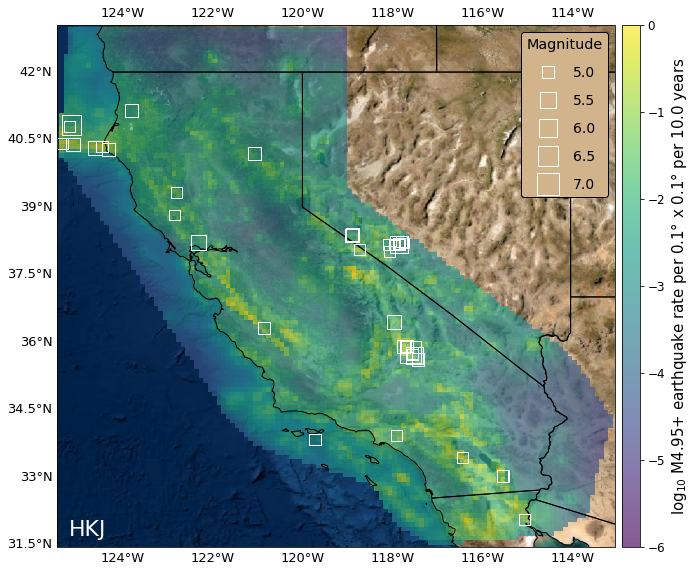

In [30]:
fig = plt.figure(figsize=(10,20))
ax_H = plot_forecast(HKJ_f, catalog_Cali2)
plt.savefig('Fig3.png', dpi=200, bbox_inches = 'tight')

#### Fig. 3: Hypocentral locations of M$\geq$4.95 earthquakes observed in the CSEP-California testing region during the 2011-2020 prospective evaluation period of this study. We include a forecast map, showing the estimates of earthquake rate densities per decade provided by the baseline HKJ model.

In [74]:
def _simulate_catalog(num_events, sampling_weights, sim_fore, random_numbers=None):

    # generate uniformly distributed random numbers in [0,1), this
    if random_numbers is None:
        random_numbers = numpy.random.rand(num_events)
    else:
        # TODO: ensure that random numbers are all between 0 and 1.
        pass

    # reset simulation array to zero, but don't reallocate
    sim_fore.fill(0)

    # find insertion points using binary search inserting to satisfy a[i-1] <= v < a[i]
    pnts = numpy.searchsorted(sampling_weights, random_numbers, side='right')

    # create simulated catalog by adding to the original locations
    numpy.add.at(sim_fore, pnts, 1)
    assert sim_fore.sum() == num_events, "simulated the wrong number of events!"

    return sim_fore

In [75]:
sampling_weights = numpy.cumsum(HKJ_f.data.ravel()) / numpy.sum(HKJ_f.data)
sim_fore = numpy.zeros(sampling_weights.shape)

sim_cat = np.zeros((len(sim_fore), 1000))
num_events_to_simulate = []

for i in range(0,1000):
    num_events_to_simulate.append(int(numpy.random.poisson(HKJ_f.event_count)))
    sim_cat[:,i] = _simulate_catalog(num_events_to_simulate[i], sampling_weights, sim_fore, random_numbers=None)

In [81]:
def _number_test_ndarray(fore_cnt, obs_cnt, epsilon=1e-6):
    """ Computes delta1 and delta2 values from the csep1 number test.

    Args:
        fore_cnt (float): parameter of poisson distribution coming from expected value of the forecast
        obs_cnt (float): count of earthquakes observed during the testing period.
        epsilon (float): tolerance level to satisfy the requirements of two-sided p-value

    Returns
        result (tuple): (delta1, delta2)
    """
    delta1 = 1.0 - scipy.stats.poisson.cdf(obs_cnt - epsilon, fore_cnt)
    delta2 = scipy.stats.poisson.cdf(obs_cnt + epsilon, fore_cnt)
    return delta1, delta2

In [82]:
def number_test(gridded_forecast, observed_catalog):
    """Computes "N-Test" on a gridded forecast.
    author: @asim

    Computes Number (N) test for Observed and Forecasts. Both data sets are expected to be in terms of event counts.
    We find the Total number of events in Observed Catalog and Forecasted Catalogs. Which are then employed to compute the probablities of
    (i) At least no. of events (delta 1)
    (ii) At most no. of events (delta 2) assuming the poissonian distribution.

    Args:
        observation: Observed (Gridded) seismicity (Numpy Array):
                    An Observation has to be Number of Events in Each Bin
                    It has to be a either zero or positive integer only (No Floating Point)
        forecast:   Forecast of a Model (Gridded) (Numpy Array)
                    A forecast has to be in terms of Average Number of Events in Each Bin
                    It can be anything greater than zero

    Returns:
        out (tuple): (delta_1, delta_2)
    """
    result = EvaluationResult()

    # observed count
    obs_cnt = sum(observed_catalog)

    # forecasts provide the expeceted number of events during the time horizon of the forecast
    fore_cnt = gridded_forecast.event_count

    epsilon = 1e-6

    # stores the actual result of the number test
    delta1, delta2 = _number_test_ndarray(fore_cnt, obs_cnt, epsilon=epsilon)

    # store results
    result.test_distribution = ('poisson', fore_cnt)
    result.name = 'Poisson N-Test'
    result.observed_statistic = obs_cnt
    result.quantile = (delta1, delta2)
    result.sim_name = gridded_forecast.name
    #result.obs_name = observed_catalog.name
    result.status = 'normal'
    result.min_mw = numpy.min(gridded_forecast.magnitudes)

    return result

In [83]:
data_n = []

for i in range(1000):
    data_n.append(number_test(HKJ_f, sim_cat[:,i]))

In [84]:
q_n = []
q_nd1 = []
q_nd2 = []

for i in range(len(data_n)):
    q_n.append(data_n[i].quantile)
    q_nd1.append(q_n[i][0])
    q_nd2.append(q_n[i][1])

In [85]:
def spatial_test(gridded_forecast, observed_catalog, num_simulations=1000, seed=None, random_numbers=None,
                 verbose=False):
    """
    Performs the Spatial Test on the Forecast using the Observed Catalogs.

    Note: The forecast and the observations should be scaled to the same time period before calling this function. This increases
    transparency as no assumptions are being made about the length of the forecasts. This is particularly important for
    gridded forecasts that supply their forecasts as rates.

    Args:
        gridded_forecast: csep.core.forecasts.GriddedForecast
        observed_catalog: csep.core.catalogs.Catalog
        num_simulations (int): number of simulations used to compute the quantile score
        seed (int): used fore reproducibility, and testing
        random_numbers (numpy.ndarray): random numbers used to override the random number generation. injection point for testing.

    Returns:
        evaluation_result: csep.core.evaluations.EvaluationResult
    """

    # grid catalog onto spatial grid
    gridded_catalog_data = observed_catalog

    # simply call likelihood test on catalog data and forecast
    qs, obs_ll, simulated_ll,sim_fore, sim_cat, sim_target_idx, num_events_to_simulate = _poisson_likelihood_test(gridded_forecast.spatial_counts(), gridded_catalog_data,
                                                        num_simulations=num_simulations,
                                                        seed=seed,
                                                        random_numbers=random_numbers,
                                                        use_observed_counts=True,
                                                        verbose=verbose,
                                                        normalize_likelihood=True)

   
    
    # populate result data structure
    result = EvaluationResult()
    result.test_distribution = simulated_ll
    result.name = 'Poisson S-Test'
    result.observed_statistic = obs_ll
    result.quantile = qs
    result.sim_name = gridded_forecast.name
    #result.obs_name = observed_catalog.name
    result.status = 'normal'
    try:
        result.min_mw = numpy.min(gridded_forecast.magnitudes)
    except AttributeError:
        result.min_mw = -1
    return result

In [86]:
data_s = []
for i in range(1000):
    data_s.append(spatial_test(HKJ_f, np.reshape(sim_cat[:,i],(7682, 41)).sum(axis=1), seed=seed, num_simulations=1000))

In [87]:
q_s = []

for i in range(len(data_s)):
    q_s.append(data_s[i].quantile)

In [89]:
def magnitude_test(gridded_forecast, observed_catalog, num_simulations=1000, seed=None, random_numbers=None,
                   verbose=False):
    """
    Performs the Magnitude Test on a Gridded Forecast using an observed catalog.

    Note: The forecast and the observations should be scaled to the same time period before calling this function. This increases
    transparency as no assumptions are being made about the length of the forecasts. This is particularly important for
    gridded forecasts that supply their forecasts as rates.

    Args:
        gridded_forecast: csep.core.forecasts.GriddedForecast
        observed_catalog: csep.core.catalogs.Catalog
        num_simulations (int): number of simulations used to compute the quantile score
        seed (int): used fore reproducibility, and testing
        random_numbers (numpy.ndarray): random numbers used to override the random number generation. injection point for testing.

    Returns:
        evaluation_result: csep.core.evaluations.EvaluationResult
    """

    # grid catalog onto spatial grid
    #gridded_catalog_data = observed_catalog.magnitude_counts(mag_bins=gridded_forecast.magnitudes)
    gridded_catalog_data = observed_catalog#.magnitude_counts(mag_bins=gridded_forecast.magnitudes)


    # simply call likelihood test on catalog data and forecast
    qs, obs_ll, simulated_ll,sim_fore, sim_cat, sim_target_idx, num_events_to_simulate = _poisson_likelihood_test(gridded_forecast.magnitude_counts(), gridded_catalog_data,
                                                        num_simulations=num_simulations,
                                                        seed=seed,
                                                        random_numbers=random_numbers,
                                                        use_observed_counts=True,
                                                        verbose=verbose,
                                                        normalize_likelihood=True)

    # populate result data structure
    result = EvaluationResult()
    result.test_distribution = simulated_ll
    result.name = 'Poisson M-Test'
    result.observed_statistic = obs_ll
    result.quantile = qs
    result.sim_name = gridded_forecast.name
    #result.obs_name = observed_catalog.name
    result.status = 'normal'
    result.min_mw = numpy.min(gridded_forecast.magnitudes)

    return result

In [90]:
data_m = []
for i in range(1000):
    data_m.append(magnitude_test(HKJ_f, np.reshape(sim_cat[:,i],(7682, 41)).sum(axis=0), seed=seed, num_simulations=1000))

In [91]:
def conditional_likelihood_test(gridded_forecast, observed_catalog, num_simulations=1000, seed=None,
                                random_numbers=None, verbose=False):
    """Performs the conditional likelihood test on Gridded Forecast using an Observed Catalog.

    This test normalizes the forecast so the forecasted rate are consistent with the observations. This modification
    eliminates the strong impact differences in the number distribution have on the forecasted rates.

    Note: The forecast and the observations should be scaled to the same time period before calling this function. This increases
    transparency as no assumptions are being made about the length of the forecasts. This is particularly important for
    gridded forecasts that supply their forecasts as rates.

    Args:
        gridded_forecast: csep.core.forecasts.GriddedForecast
        observed_catalog: csep.core.catalogs.Catalog
        num_simulations (int): number of simulations used to compute the quantile score
        seed (int): used fore reproducibility, and testing
        random_numbers (numpy.ndarray): random numbers used to override the random number generation. injection point for testing.

    Returns:
        evaluation_result: csep.core.evaluations.EvaluationResult
    """

    gridded_catalog_data = np.reshape(observed_catalog,(7682, 41)) #observed_catalog.spatial_magnitude_counts()

    # simply call likelihood test on catalog data and forecast
    qs, obs_ll, simulated_ll, sim_fore, sim_cat, sim_target_idx, num_events_to_simulate = _poisson_likelihood_test(gridded_forecast.data, gridded_catalog_data,
                                                        num_simulations=num_simulations,
                                                        seed=seed,
                                                        random_numbers=random_numbers,
                                                        use_observed_counts=True,
                                                        verbose=verbose,
                                                        normalize_likelihood=False)

    # populate result data structure
    result = EvaluationResult()
    result.test_distribution = simulated_ll
    result.name = 'Poisson CL-Test'
    result.observed_statistic = obs_ll
    result.sim_fore = sim_fore
    #result.sim_obs_nonzero = sim_obs_nonzero
    result.quantile = qs
    result.sim_target_idx = sim_target_idx
    result.sim_name = gridded_forecast.name
    #result.obs_name = observed_catalog.name
    result.status = 'normal'
    result.num_events_to_simulate = num_events_to_simulate
    result.sim_cat = sim_cat
    result.min_mw = numpy.min(gridded_forecast.magnitudes)

    return result

In [92]:
data_cl = []
for i in range(1000):
    data_cl.append(conditional_likelihood_test(HKJ_f, sim_cat[:,i], seed=seed, num_simulations=1000))

In [95]:
q_cl = []

for i in range(len(data_cl)):
    q_cl.append(data_cl[i].quantile)

/tmp/ipykernel_30038/1471479548.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=13)
/tmp/ipykernel_30038/1471479548.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(x, fontsize=13)


(-0.05, 1.05)

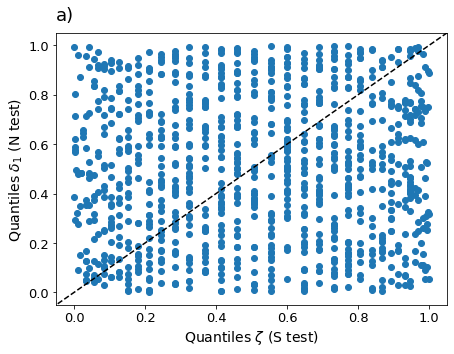

In [93]:
fig, ax = plt.subplots(figsize=(7,5))

d1_s = ax.scatter(q_nd1, q_s)

x=['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0']

ax.set_xticklabels(x, fontsize=13)
ax.set_yticklabels(x, fontsize=13)

ax.set_xlabel(r'Quantiles $\zeta$ (S test)', fontsize = 14)
ax.set_ylabel(r'Quantiles $\delta_1$ (N test)' , fontsize = 14)

ax.plot((-1.0, 2), (-1.0, 2),'k--', linewidth=1.5)
ax.text(-0.05, 1.1, 'a)', fontsize =18, color='black')

ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)

#plt.savefig('Fig4a.png', dpi=100, bbox_inches = 'tight')

/tmp/ipykernel_30038/3016963244.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=13)
/tmp/ipykernel_30038/3016963244.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(x, fontsize=13)


(-0.05, 1.05)

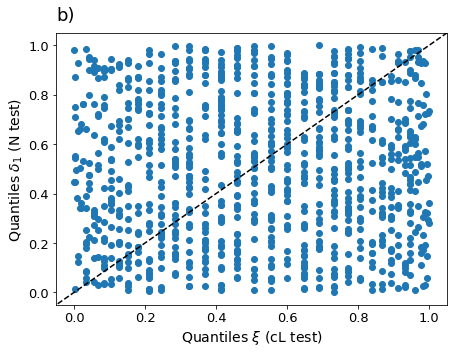

In [96]:
fig, ax = plt.subplots(figsize=(7,5))

d1_cl = ax.scatter(q_nd1, q_cl)

x=['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0']

ax.set_xticklabels(x, fontsize=13)
ax.set_yticklabels(x, fontsize=13)

ax.set_xlabel(r'Quantiles $\xi$ (cL test)', fontsize = 14)
ax.set_ylabel(r'Quantiles $\delta_1$ (N test)' , fontsize = 14)

ax.plot((-1.0, 2), (-1.0, 2),'k--', linewidth=1.5)
ax.text(-0.05, 1.1, 'b)', fontsize =18, color='black')

ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)

#plt.savefig('Fig4b.png', dpi=100, bbox_inches = 'tight')

/tmp/ipykernel_30038/3701287223.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=13)
/tmp/ipykernel_30038/3701287223.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(x, fontsize=13)


(-0.05, 1.05)

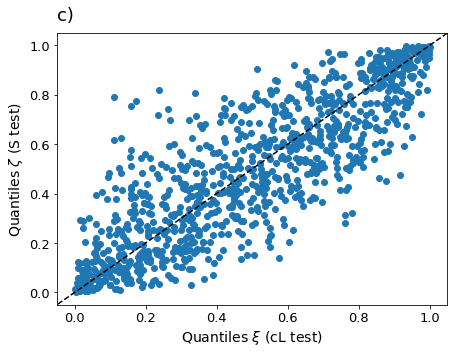

In [97]:
fig, ax = plt.subplots(figsize=(7,5))

cl_s = ax.scatter(q_cl,q_s)

x=['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0']

ax.set_xticklabels(x, fontsize=13)
ax.set_yticklabels(x, fontsize=13)

ax.set_xlabel(r'Quantiles $\xi$ (cL test)', fontsize = 14)
ax.set_ylabel(r'Quantiles $\zeta$ (S test)', fontsize = 14)

ax.plot((-1.0, 2), (-1.0, 2),'k--', linewidth=1.5)
ax.text(-0.05, 1.1, 'c)', fontsize =18, color='black')

ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)
#plt.savefig('Fig4c.png', dpi=100, bbox_inches = 'tight')

## Consistency tests:

### N tests:

#### NBD N-test:

In [25]:
# We use the historical ANSS catalog to fit a negative binomial distribution (NBD) to the number distribution
# predicted by each forecast:
# To do so, we first estimate the number of earthquakes observed in the testing HKJ, Kagan, Shen and Ward regions during non-overlapping 10-yr periods.

rates = pd.read_csv('bnd1932.txt', sep='\t', skiprows=0) 

#Then, we calculate the variance of each dataset:
var_HKJ = rates.HKJ.var()
var_Shen = rates.Shen.var()
var_Ward = rates.Ward.var()

In [61]:
# Thus, we compute the shape parameters of BND, tau and upsilon from the expected earthquake number
# provided by the forecast (mean), and the observed number variance (var). As a result, this function 
# provides 'invals' BND predictive ranges centered in the expected number value of each forecast, and delta1
# and delta2 quantiles:

def binomial_n_test(forecast, catalog):
    
    Bonferroni = 0.05 / 2
    if len(forecast.data) == 7682:
        var = var_HKJ
        mean = forecast.event_count
        upsilon = 1.0 - ((var - mean) / var)
        tau = (mean**2 /(var - mean))
        invals = nbinom.interval(0.95, tau, upsilon, loc=0) 
        #holi = scipy.stats.nbinom.ppf(0.95, tau, upsilon, loc=0)
        delta1 = 1.0 - scipy.stats.nbinom.cdf(catalog.event_count, tau, upsilon, loc=0)
        delta2 = scipy.stats.nbinom.cdf(catalog.event_count, tau, upsilon, loc=0)
     
    elif len(forecast.data) == 3410:
        var = var_Shen
        mean = forecast.event_count
        upsilon = 1.0 - ((var - mean) / var)
        tau = (mean**2 /(var - mean))
        invals = nbinom.interval(0.95, tau, upsilon, loc=0) 
        #invalsb = nbinom.interval(0.975, tau, upsilon, loc=0) 
        delta1 = 1.0 - scipy.stats.nbinom.cdf(catalog.event_count, tau, upsilon, loc=0)
        delta2 = scipy.stats.nbinom.cdf(catalog.event_count, tau, upsilon, loc=0)
        #holi = scipy.stats.nbinom.ppf(0.95, tau, upsilon, loc=0)
        
    elif len(forecast.data) == 2053:
        var = var_Ward
        mean = forecast.event_count
        upsilon = 1.0 - ((var - mean) / var)
        tau = (mean**2 /(var - mean))
        invals = nbinom.interval(0.95, tau, upsilon, loc=0) 
        #invalsb = nbinom.interval(0.975, tau, upsilon, loc=0) 
        delta1 = 1.0 - scipy.stats.nbinom.cdf(catalog.event_count, tau, upsilon, loc=0)
        delta2 = scipy.stats.nbinom.cdf(catalog.event_count, tau, upsilon, loc=0)
        holi = scipy.stats.nbinom.ppf(0.95, tau, upsilon, loc=0)
    
    return var, invals, delta1, delta2, tau, upsilon

In [62]:
# HKJ/ California testing region:
NBD_HKJ = binomial_n_test(HKJ_f, catalog_Cali2)
NBD_Bird = binomial_n_test(Bird_f, catalog_Cali2)
NBD_PI = binomial_n_test(PI_f, catalog_Cali2)
NBD_HKJ_ALM = binomial_n_test(HKJ_ALMf, catalog_Cali2)
NBD_HKJ_Bird = binomial_n_test(HKJ_Birdf, catalog_Cali2)
NBD_HKJ_Bird_PI = binomial_n_test(HKJ_Bird_PIf, catalog_Cali2)
NBD_HKJ_PI = binomial_n_test(HKJ_PIf, catalog_Cali2)
NBD_Ebel = binomial_n_test(Ebel_cf, catalog_Ebel)
NBD_HKJ_Ebel = binomial_n_test(HKJ_Ebelf, catalog_Ebel)

NBD_Kagan = binomial_n_test(Kagan_f, catalog_Kagan)
NBD_Shen = binomial_n_test(Shen_f, catalog_Shen)
NBD_HKJ_Kagan = binomial_n_test(HKJ_Kaganf, catalog_HKJ_Kagan)
NBD_HKJ_Bird_sca = binomial_n_test(HKJ_Bird_scaf, catalog_Shen)
NBD_HKJ_PI_sca = binomial_n_test(HKJ_PI_scaf, catalog_Shen)
NBD_HKJ_Shen = binomial_n_test(HKJ_Shenf, catalog_Shen)
NBD_HKJ_Shen_PI = binomial_n_test(HKJ_Shen_PIf, catalog_Shen)

# Ward/ southern California testing region:
NBD_HKJ_Ward_combo = binomial_n_test(HKJ_Ward_combof, catalog_Ward)
NBD_HKJ_Ward_geod81 = binomial_n_test(HKJ_Ward_geod81f, catalog_Ward)
NBD_HKJ_Ward_geod85 = binomial_n_test(HKJ_Ward_geod85f, catalog_Ward)
NBD_HKJ_Ward_geol = binomial_n_test(HKJ_Ward_geolf, catalog_Ward)
NBD_HKJ_Ward_seis = binomial_n_test(HKJ_Ward_seisf, catalog_Ward)
NBD_HKJ_Ward_sim = binomial_n_test(HKJ_Ward_simf, catalog_Ward)

In [28]:
# Number-tests for earthquake forecasts in California:
ntest_Bird = poisson.number_test(Bird_f, catalog_Cali2)
ntest_HKJ = poisson.number_test(HKJ_f, catalog_Cali2)
ntest_PI = poisson.number_test(PI_f, catalog_Cali2)
ntest_HKJ_ALM = poisson.number_test(HKJ_ALMf, catalog_Cali2)
ntest_HKJ_Bird = poisson.number_test(HKJ_Birdf, catalog_Cali2)
ntest_HKJ_Bird_PI = poisson.number_test(HKJ_Bird_PIf, catalog_Cali2)
ntest_HKJ_PI = poisson.number_test(HKJ_PIf, catalog_Cali2)
ntest_Ebel = poisson.number_test(Ebel_cf, catalog_Ebel)
ntest_HKJ_Ebel = poisson.number_test(HKJ_Ebelf, catalog_Ebel)

# Number-tests for earthquake forecasts in southern California:
ntest_Kagan = poisson.number_test(Kagan_f, catalog_Kagan)
ntest_Shen = poisson.number_test(Shen_f, catalog_Shen)
ntest_HKJ_Kagan = poisson.number_test(HKJ_Kaganf, catalog_HKJ_Kagan)
ntest_HKJ_Bird_sca = poisson.number_test(HKJ_Bird_scaf, catalog_Shen)
ntest_HKJ_PI_sca = poisson.number_test(HKJ_PI_scaf, catalog_Shen)
ntest_HKJ_Shen = poisson.number_test(HKJ_Shenf, catalog_Shen)
ntest_HKJ_Shen_PI = poisson.number_test(HKJ_Shen_PIf, catalog_Shen)
ntest_HKJ_Ward_combo = poisson.number_test(HKJ_Ward_combof, catalog_Ward)
ntest_HKJ_Ward_geod81 = poisson.number_test(HKJ_Ward_geod81f, catalog_Ward)
ntest_HKJ_Ward_geod85 = poisson.number_test(HKJ_Ward_geod85f, catalog_Ward)
ntest_HKJ_Ward_geol = poisson.number_test(HKJ_Ward_geolf, catalog_Ward)
ntest_HKJ_Ward_seis = poisson.number_test(HKJ_Ward_seisf, catalog_Ward)
ntest_HKJ_Ward_sim = poisson.number_test(HKJ_Ward_simf, catalog_Ward)

In [44]:
def plot_poisson_consistency_test(eval_results, normalize=False, one_sided_lower=True, plot_args=None):
    """ Plots results from CSEP1 tests following the CSEP1 convention.

    Note: All of the evaluations should be from the same type of evaluation, otherwise the results will not be
          comparable on the same figure.

    Args:
        results (list): Contains the tests results :class:`csep.core.evaluations.EvaluationResult` (see note above)
        normalize (bool): select this if the forecast likelihood should be normalized by the observed likelihood. useful
                          for plotting simulation based simulation tests.
        one_sided_lower (bool): select this if the plot should be for a one sided test
        plot_args(dict): optional argument containing a dictionary of plotting arguments, with keys as strings and items as described below

    Optional plotting arguments:
        * figsize: (:class:`list`/:class:`tuple`) - default: [6.4, 4.8]
        * title: (:class:`str`) - default: name of the first evaluation result type
        * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 10
        * xlabel: (:class:`str`) - default: 'X'
        * xlabel_fontsize: (:class:`float`) - default: 10
        * xticks_fontsize: (:class:`float`) - default: 10
        * ylabel_fontsize: (:class:`float`) - default: 10
        * color: (:class:`float`/:class:`None`) If None, sets it to red/green according to :func:`_get_marker_style` - default: 'black'
        * linewidth: (:class:`float`) - default: 1.5
        * capsize: (:class:`float`) - default: 4
        * hbars:  (:class:`bool`)  Flag to draw horizontal bars for each model - default: True
        * tight_layout: (:class:`bool`) Set matplotlib.figure.tight_layout to remove excess blank space in the plot - default: True

    Returns:
        ax (:class:`matplotlib.pyplot.axes` object)
    """


    try:
        results = list(eval_results)
    except TypeError:
        results = [eval_results]
    results.reverse()
    # Parse plot arguments. More can be added here
    if plot_args is None:
        plot_args = {}
    figsize= plot_args.get('figsize', (7,8))
    title = plot_args.get('title', results[0].name)
    title_fontsize = plot_args.get('title_fontsize', None)
    xlabel = plot_args.get('xlabel', 'X')
    xlabel_fontsize = plot_args.get('xlabel_fontsize', None)
    xticks_fontsize = plot_args.get('xticks_fontsize', None)
    ylabel_fontsize = plot_args.get('ylabel_fontsize', None)
    color = plot_args.get('color', 'black')
    linewidth = plot_args.get('linewidth', None)
    capsize = plot_args.get('capsize', 4)
    hbars = plot_args.get('hbars', True)
    tight_layout = plot_args.get('tight_layout', True)

    fig, ax = plt.subplots(figsize=figsize)
    xlims = []
    for index, res in enumerate(results):
        # handle analytical distributions first, they are all in the form ['name', parameters].
        if res.test_distribution[0] == 'poisson':
            plow = scipy.stats.poisson.ppf(0.025, res.test_distribution[1])
            phigh = scipy.stats.poisson.ppf(0.975, res.test_distribution[1])
            observed_statistic = res.observed_statistic
        # empirical distributions
        else:
            if normalize:
                test_distribution = numpy.array(res.test_distribution) - res.observed_statistic
                observed_statistic = 0
            else:
                test_distribution = numpy.array(res.test_distribution)
                observed_statistic = res.observed_statistic
            # compute distribution depending on type of test
            if one_sided_lower:
                plow = numpy.percentile(test_distribution, 5)
                phigh = numpy.percentile(test_distribution, 100)
            else:
                plow = numpy.percentile(test_distribution, 2.5)
                phigh = numpy.percentile(test_distribution, 97.5)

        if not numpy.isinf(observed_statistic): # Check if test result does not diverges
            low = observed_statistic - plow
            high = phigh - observed_statistic
            ax.errorbar(observed_statistic, index, xerr=numpy.array([[low, high]]).T,
                        fmt=_get_marker_style(observed_statistic, (plow, phigh), one_sided_lower),
                        capsize=4, linewidth=0, ecolor='None', markersize = 10, zorder=1)
            # determine the limits to use
            xlims.append((plow, phigh, observed_statistic))
            # we want to only extent the distribution where it falls outside of it in the acceptable tail
            if one_sided_lower:
                if observed_statistic >= plow and phigh < observed_statistic:
                    # draw dashed line to infinity
                    xt = numpy.linspace(phigh, 99999, 100)
                    yt = numpy.ones(100) * index
                    ax.plot(xt, yt, linestyle='--', linewidth=linewidth, color=color)

        else:
            print('Observed statistic diverges for forecast %s, index %i.'
                  ' Check for zero-valued bins within the forecast'% (res.sim_name, index))
            ax.barh(index, 99999, left=-10000, height=1, color=['red'], alpha=0.5)


    try:
        ax.set_xlim(*_get_axis_limits(xlims))
    except ValueError:
        raise ValueError('All EvaluationResults have infinite observed_statistics')
    ax.set_yticks(numpy.arange(len(results)))
    ax.set_yticklabels([res.sim_name for res in results], fontsize=14)
    ax.set_ylim([-0.5, len(results)-0.5])
    if hbars:
        yTickPos = ax.get_yticks()
        if len(yTickPos) >= 2:
            ax.barh(yTickPos, numpy.array([99999] * len(yTickPos)), left=-10000,
                    height=(yTickPos[1] - yTickPos[0]), color=['w', 'gray'], alpha=0.2, zorder=0)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='x', labelsize=13)
    if tight_layout:
        ax.figure.tight_layout()
        fig.tight_layout()
    return ax

In [45]:
def _get_marker_style(obs_stat, p, one_sided_lower):
    """Returns matplotlib marker style as fmt string"""
    if obs_stat < p[0] or obs_stat > p[1]:
        # red circle
        fmt = 'ko'
    else:
        # green square
        fmt = 'ko'
    if one_sided_lower:
        if obs_stat < p[0]:
            fmt = 'ko'
        else:
            fmt = 'ko'
    return fmt

In [46]:
def _get_axis_limits(pnts, border=0.05):
    """Returns a tuple of x_min and x_max given points on plot."""
    x_min = numpy.min(pnts)
    x_max = numpy.max(pnts)
    xd = (x_max - x_min)*border
    return (x_min-xd, x_max+xd)

/home/tono/anaconda3/envs/gji-hybrids/lib/python3.10/site-packages/numpy/lib/twodim_base.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asanyarray(m)


<Figure size 432x288 with 0 Axes>

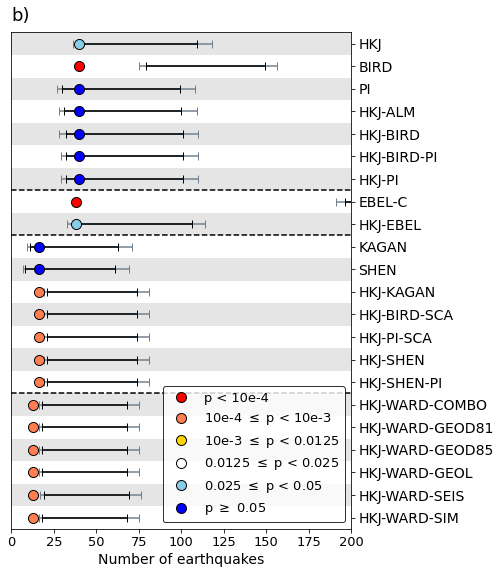

In [69]:
fig = plt.figure()

poisson_Ntests = [ntest_HKJ, ntest_Bird, ntest_PI, ntest_HKJ_ALM, ntest_HKJ_Bird, ntest_HKJ_Bird_PI, 
                  ntest_HKJ_PI, ntest_Ebel, ntest_HKJ_Ebel, ntest_Kagan, ntest_Shen, ntest_HKJ_Kagan, 
                  ntest_HKJ_Bird_sca, ntest_HKJ_PI_sca, ntest_HKJ_Shen, ntest_HKJ_Shen_PI, ntest_HKJ_Ward_combo, 
                  ntest_HKJ_Ward_geod81, ntest_HKJ_Ward_geod85, ntest_HKJ_Ward_geol, ntest_HKJ_Ward_seis, ntest_HKJ_Ward_sim]

bi_Ntests = [NBD_HKJ_Ward_sim, NBD_HKJ_Ward_seis, NBD_HKJ_Ward_geol, NBD_HKJ_Ward_geod85, 
              NBD_HKJ_Ward_geod81, NBD_HKJ_Ward_combo, NBD_HKJ_Shen_PI, NBD_HKJ_Shen, NBD_HKJ_PI_sca,
              NBD_HKJ_Bird_sca, NBD_HKJ_Kagan, NBD_Shen, NBD_Kagan, NBD_HKJ_Ebel, NBD_Ebel, 
              NBD_HKJ_PI, NBD_HKJ_Bird_PI, NBD_HKJ_Bird, NBD_HKJ_ALM, NBD_PI, NBD_Bird, NBD_HKJ]

bi_Ntests_aux = np.flipud(bi_Ntests)

ax_nb = plot_poisson_consistency_test(poisson_Ntests, plot_args={'xlabel': 'Number of earthquakes'})
 
pnb_values = []
for i in range(len(bi_Ntests)):
    plow95 = scipy.stats.nbinom.ppf(0.025, bi_Ntests_aux[i][4], bi_Ntests_aux[i][5])
    phigh95 = scipy.stats.nbinom.ppf(0.975, bi_Ntests_aux[i][4], bi_Ntests_aux[i][5])
    low95 = poisson_Ntests[i].observed_statistic - plow95
    high95 = phigh95 - poisson_Ntests[i].observed_statistic 
    
    plow97 = scipy.stats.nbinom.ppf(0.0125, bi_Ntests_aux[i][4], bi_Ntests_aux[i][5])
    phigh97 = scipy.stats.nbinom.ppf(0.99, bi_Ntests_aux[i][4], bi_Ntests_aux[i][5])
    low97 = poisson_Ntests[i].observed_statistic - plow97
    high97 = phigh97 - poisson_Ntests[i].observed_statistic 
    pnb_values.append(bi_Ntests[i][3] * 2)
    
    ax_nb.errorbar(poisson_Ntests[i].observed_statistic, 21 -i, xerr=numpy.array([[low97, high97]]).T, capsize=4, 
                  color='slategray', alpha=1.0, zorder=0)
    ax_nb.errorbar(poisson_Ntests[i].observed_statistic, 21 -i, xerr=numpy.array([[low95, high95]]).T, capsize=4, 
                  color='black', alpha=1.0, zorder=0) 
        
    if bi_Ntests_aux[i][3] <= 10e-4:
        ax_nb.plot(poisson_Ntests[i].observed_statistic, 21 -i, marker='o', color = 'red', markersize= 8, zorder=2)
    
    if bi_Ntests_aux[i][3] > 10e-4 and bi_Ntests_aux[i][3] <= 10e-3:
        ax_nb.plot(poisson_Ntests[i].observed_statistic, 21 -i, marker='o', color = '#FF7F50', markersize= 8, zorder=2)
        
    if bi_Ntests_aux[i][3] > 10e-3 and bi_Ntests_aux[i][3] <= 0.0125:
        ax_nb.plot(poisson_Ntests[i].observed_statistic, 21 -i, marker='o', color = 'gold', markersize= 8, zorder=2)
        
    if bi_Ntests_aux[i][3] > 0.0125 and bi_Ntests_aux[i][3] <= 0.025:
        ax_nb.plot(poisson_Ntests[i].observed_statistic, 21 -i, marker='o', color = 'white', markersize= 8, zorder=2)
        
    if bi_Ntests_aux[i][3] > 0.025 and bi_Ntests_aux[i][3] <= 0.05:
        ax_nb.plot(poisson_Ntests[i].observed_statistic, 21 -i, marker='o', color = 'skyblue', markersize= 8, zorder=2)    
    
    if bi_Ntests_aux[i][3] > 0.05:
        ax_nb.plot(poisson_Ntests[i].observed_statistic, 21 -i, marker='o', color = 'blue', markersize= 8, zorder=2)
    
ax_nb.yaxis.tick_right()
ax_nb.set_xlim(0,200)
ax_nb.set_title('')
ax_nb.plot((0.0, 200), (5.5, 5.5),'k--', linewidth=1.5)
ax_nb.plot((0.0, 200), (12.5, 12.5),'k--', linewidth=1.5)
ax_nb.plot((0.0, 200), (14.5, 14.5),'k--', linewidth=1.5)
ax_nb.text(0.0, 22., 'b)', fontsize =18, color='black')

legend_elements = [Line2D([0], [0], marker='o', color='red', lw=0, label=r'p < 10e-4', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='#FF7F50', lw=0, label=r'10e-4 $\leq$ p < 10e-3', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='gold', lw=0, label=r'10e-3 $\leq$ p < 0.0125', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='white', lw=0, label=r'0.0125 $\leq$ p < 0.025', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='skyblue', lw=0, label=r'0.025 $\leq$ p < 0.05', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='blue', lw=0, label=r'p $\geq$ 0.05', markersize=10, markeredgecolor='k')]

ax_nb.legend(handles=legend_elements, loc=4, fontsize=13, edgecolor='k')  

#plt.savefig('Fig5b.png', dpi=200, bbox_inches = 'tight')

####  Poisson N-test:

In [33]:
def plot_poisson_consistency_test(eval_results, normalize=False, one_sided_lower=True, plot_args=None):
    """ Plots results from CSEP1 tests following the CSEP1 convention.

    Note: All of the evaluations should be from the same type of evaluation, otherwise the results will not be
          comparable on the same figure.

    Args:
        results (list): Contains the tests results :class:`csep.core.evaluations.EvaluationResult` (see note above)
        normalize (bool): select this if the forecast likelihood should be normalized by the observed likelihood. useful
                          for plotting simulation based simulation tests.
        one_sided_lower (bool): select this if the plot should be for a one sided test
        plot_args(dict): optional argument containing a dictionary of plotting arguments, with keys as strings and items as described below

    Optional plotting arguments:
        * figsize: (:class:`list`/:class:`tuple`) - default: [6.4, 4.8]
        * title: (:class:`str`) - default: name of the first evaluation result type
        * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 10
        * xlabel: (:class:`str`) - default: 'X'
        * xlabel_fontsize: (:class:`float`) - default: 10
        * xticks_fontsize: (:class:`float`) - default: 10
        * ylabel_fontsize: (:class:`float`) - default: 10
        * color: (:class:`float`/:class:`None`) If None, sets it to red/green according to :func:`_get_marker_style` - default: 'black'
        * linewidth: (:class:`float`) - default: 1.5
        * capsize: (:class:`float`) - default: 4
        * hbars:  (:class:`bool`)  Flag to draw horizontal bars for each model - default: True
        * tight_layout: (:class:`bool`) Set matplotlib.figure.tight_layout to remove excess blank space in the plot - default: True

    Returns:
        ax (:class:`matplotlib.pyplot.axes` object)
    """


    try:
        results = list(eval_results)
    except TypeError:
        results = [eval_results]
    results.reverse()
    # Parse plot arguments. More can be added here
    if plot_args is None:
        plot_args = {}
    figsize= plot_args.get('figsize', (7,8))
    title = plot_args.get('title', results[0].name)
    title_fontsize = plot_args.get('title_fontsize', None)
    xlabel = plot_args.get('xlabel', 'X')
    xlabel_fontsize = plot_args.get('xlabel_fontsize', None)
    xticks_fontsize = plot_args.get('xticks_fontsize', None)
    ylabel_fontsize = plot_args.get('ylabel_fontsize', None)
    color = plot_args.get('color', 'black')
    linewidth = plot_args.get('linewidth', None)
    capsize = plot_args.get('capsize', 4)
    hbars = plot_args.get('hbars', True)
    tight_layout = plot_args.get('tight_layout', True)

    fig, ax = plt.subplots(figsize=figsize)
    xlims = []
    for index, res in enumerate(results):
        # handle analytical distributions first, they are all in the form ['name', parameters].
        if res.test_distribution[0] == 'poisson':
            plow = scipy.stats.poisson.ppf(0.025, res.test_distribution[1])
            phigh = scipy.stats.poisson.ppf(0.975, res.test_distribution[1])
            observed_statistic = res.observed_statistic
        # empirical distributions
        else:
            if normalize:
                test_distribution = numpy.array(res.test_distribution) - res.observed_statistic
                observed_statistic = 0
            else:
                test_distribution = numpy.array(res.test_distribution)
                observed_statistic = res.observed_statistic
            # compute distribution depending on type of test
            if one_sided_lower:
                plow = numpy.percentile(test_distribution, 5)
                phigh = numpy.percentile(test_distribution, 100)
            else:
                plow = numpy.percentile(test_distribution, 2.5)
                phigh = numpy.percentile(test_distribution, 97.5)

        if not numpy.isinf(observed_statistic): # Check if test result does not diverges
            low = observed_statistic - plow
            high = phigh - observed_statistic
            ax.errorbar(observed_statistic, index, xerr=numpy.array([[low, high]]).T,
                        fmt=_get_marker_style(observed_statistic, (plow, phigh), one_sided_lower),
                        capsize=4, linewidth=linewidth, ecolor=color, markersize = 10, zorder=1)
            # determine the limits to use
            xlims.append((plow, phigh, observed_statistic))
            # we want to only extent the distribution where it falls outside of it in the acceptable tail
            if one_sided_lower:
                if observed_statistic >= plow and phigh < observed_statistic:
                    # draw dashed line to infinity
                    xt = numpy.linspace(phigh, 99999, 100)
                    yt = numpy.ones(100) * index
                    ax.plot(xt, yt, linestyle='--', linewidth=linewidth, color=color)

        else:
            print('Observed statistic diverges for forecast %s, index %i.'
                  ' Check for zero-valued bins within the forecast'% (res.sim_name, index))
            ax.barh(index, 99999, left=-10000, height=1, color=['red'], alpha=0.5)


    try:
        ax.set_xlim(*_get_axis_limits(xlims))
    except ValueError:
        raise ValueError('All EvaluationResults have infinite observed_statistics')
    ax.set_yticks(numpy.arange(len(results)))
    ax.set_yticklabels([res.sim_name for res in results], fontsize=14)
    ax.set_ylim([-0.5, len(results)-0.5])
    if hbars:
        yTickPos = ax.get_yticks()
        if len(yTickPos) >= 2:
            ax.barh(yTickPos, numpy.array([99999] * len(yTickPos)), left=-10000,
                    height=(yTickPos[1] - yTickPos[0]), color=['w', 'gray'], alpha=0.2, zorder=0)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='x', labelsize=13)
    if tight_layout:
        ax.figure.tight_layout()
        fig.tight_layout()
    return ax

Text(0.0, 22.0, 'a)')

<Figure size 432x288 with 0 Axes>

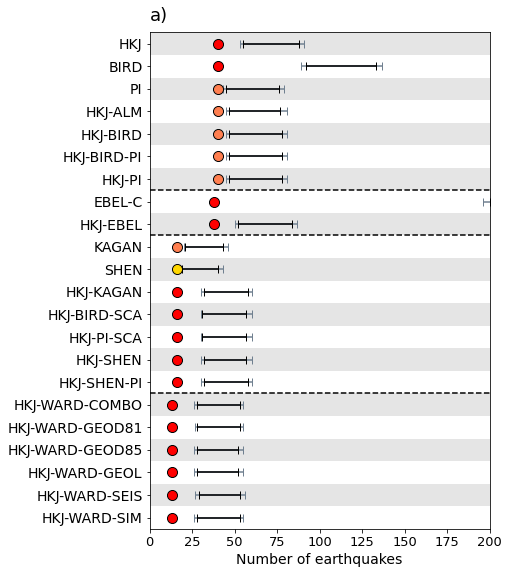

In [41]:
plt.figure()

poisson_Ntests = [ntest_HKJ, ntest_Bird, ntest_PI, ntest_HKJ_ALM, ntest_HKJ_Bird, ntest_HKJ_Bird_PI, 
                  ntest_HKJ_PI, ntest_Ebel, ntest_HKJ_Ebel, ntest_Kagan, ntest_Shen, ntest_HKJ_Kagan, 
                  ntest_HKJ_Bird_sca, ntest_HKJ_PI_sca, ntest_HKJ_Shen, ntest_HKJ_Shen_PI, ntest_HKJ_Ward_combo, 
                  ntest_HKJ_Ward_geod81, ntest_HKJ_Ward_geod85, ntest_HKJ_Ward_geol, ntest_HKJ_Ward_seis, ntest_HKJ_Ward_sim] 

ax_n = plot_poisson_consistency_test(poisson_Ntests, plot_args={'xlabel': 'Number of earthquakes'})

pn_values = []
for i in range(len(poisson_Ntests)):
    plow97 = scipy.stats.poisson.ppf(0.0125, poisson_Ntests[i].test_distribution[1])
    phigh97 = scipy.stats.poisson.ppf(0.99, poisson_Ntests[i].test_distribution[1])
    low97 = poisson_Ntests[i].observed_statistic - plow97
    high97 = phigh97 - poisson_Ntests[i].observed_statistic 
    pn_values.append(poisson_Ntests[i].quantile[1] * 2)
    ax_n.errorbar(poisson_Ntests[i].observed_statistic, 21 -i, xerr=numpy.array([[low97, high97]]).T, capsize=4, 
                  color='slategray', alpha=1.0, zorder=0)
        
    if pn_values[i] < 10e-4:
         ax_n.plot(poisson_Ntests[i].observed_statistic, 21 - i, marker='o', color = 'red', markersize= 8, zorder=2)
    
    if pn_values[i] >= 10e-4 and pn_values[i] < 10e-3:
         ax_n.plot(poisson_Ntests[i].observed_statistic, 21 - i, marker='o', color = '#FF7F50', markersize= 8, zorder=2)
        
    if pn_values[i] >= 10e-3 and pn_values[i] < 10e-2:
         ax_n.plot(poisson_Ntests[i].observed_statistic, 21 - i, marker='o', color = 'gold', markersize= 8, zorder=2)
        
    if pn_values[i] >= 10e-2 and pn_values[i] < 0.0125:
        ax_n.plot(poisson_Ntests[i].observed_statistic, 21 - i, marker='o', color = 'white', markersize= 8, zorder=2)
        
    if pn_values[i] >= 0.125 and pn_values[i] < 0.25:
        ax_n.plot(poisson_Ntests[i].observed_statistic, 21 - i, marker='o', color = 'skyblue', markersize= 8, zorder=2)    
    
    if pn_values[i] > 0.25:
         ax_n.plot(poisson_Ntests[i].observed_statistic, 21 - i, marker='o', color = '#069AF3', markersize= 8, zorder=2)
    
ax_n.set_xlim(0.0,200)
ax_n.set_title('')
ax_n.plot((0.0, 200), (5.5, 5.5),'k--', linewidth=1.5)
ax_n.plot((0.0, 200), (12.5, 12.5),'k--', linewidth=1.5)
ax_n.plot((0.0, 200), (14.5, 14.5),'k--', linewidth=1.5)
ax_n.text(0.0, 22., 'a)', fontsize =18, color='black')

#plt.savefig('Fig5a.png', dpi=100, bbox_inches = 'tight')

#### Fig. 5: Results of the prospective a) Poisson and b) NBD N-tests during the 2011-2020 evaluation period. The circles represent the number of observed earthquakes and the colors denote the calculated p-values for earthquake forecasting models, obtained from the equation p-value = 2 $\cdot$ min (P(X) $\leq$ x, P(X) > x) proposed by Meletti et al. (2021). Blue colors indicate consistencies between forecasts and the observations and red-ornage colors indicate the opposite. Solid black and gray bars depict the 95% and 97.5% predicitve intervals of the model forecast likelihood distributions. Horizontal dashed lines separate different testing regions. The EBEL-C predictive range is too large to be shown.

In [38]:
nbd = pd.read_csv('BND_database1936_10yr.txt', sep='\t', skiprows=0) 

/tmp/ipykernel_25787/800142348.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a, rotation = 0, horizontalalignment='center', fontsize=13)


Text(-0.65, 95, 'a)')

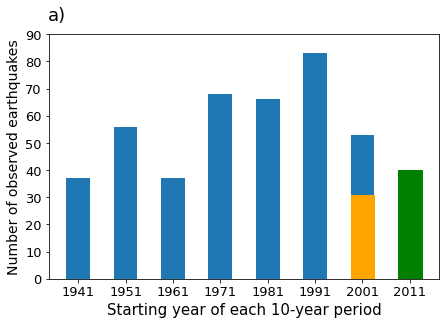

In [39]:
fig, ax = plt.subplots(figsize=(7,4.5))
x = np.arange(len(nbd.HKJ))
y = nbd.HKJ
width = 0.5  # the width of the bars
z = ax.bar(x, y, width)
ze = ax.bar(6,31,width)
ax.set_xlabel('Starting year of each 10-year period', fontsize = 15)
ax.set_ylabel('Number of observed earthquakes', fontsize = 14)
a = ['1941','1951','1961','1971','1981','1991','2001','2011']


z[7].set_color('green')
ze[0].set_color('orange')
ax.set_xticklabels(a, rotation = 0, horizontalalignment='center', fontsize=13)   
ax.tick_params(axis='y', which='major', labelsize=13)   

a2 =plt.xticks(np.arange(0,8,1))   

ax.set_ylim(0,90)
ax.text(-0.65, 95, 'a)', fontsize =18, color='black')

plt.savefig('Fig5a.png', dpi=200, bbox_inches = 'tight')

In [40]:
nbd_sc = pd.read_csv('BND_database1936_sC_10yr.txt', sep='\t', skiprows=0) 

/tmp/ipykernel_25787/1280171416.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a, rotation = 0, horizontalalignment='center', fontsize=13)


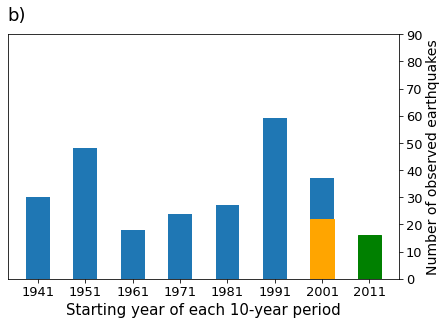

In [41]:
fig, ax = plt.subplots(figsize=(7,4.5))
x = np.arange(len(nbd_sc.SHEN))
y = nbd_sc.SHEN
width = 0.5  # the width of the bars
z = ax.bar(x, y, width)
ze = ax.bar(6,22,width)
ax.set_xlabel('Starting year of each 10-year period', fontsize = 15)
ax.set_ylabel('Number of observed earthquakes', fontsize = 14)
a = ['1941','1951','1961','1971','1981', '1991','2001','2011']

ze[0].set_color('orange')
z[7].set_color('green')

ax.set_xticklabels(a, rotation = 0, horizontalalignment='center', fontsize=13)   
ax.tick_params(axis='y', which='major', labelsize=13)   

a2 =plt.xticks(np.arange(0,8,1))   

ax.set_ylim(0,90)

ax.text(-0.65, 95, 'b)', fontsize =18, color='black')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

plt.savefig('Fig5b.png', dpi=200, bbox_inches = 'tight')

#### Fig. 5: Number of M$\geq$4.95 earthquakes observed within a) the CSEP California and b) the SHEN southern California testing regions during non-overlapping five-year periods, according to the ANSS catalogue. We highlight in orange the number of earthquakes that were used to fit hybrid models and, in green, the prospective target events.

### S tests:

#### Poisson S-test:

In [70]:
def _get_axis_limits(pnts, border=0.05):
    """Returns a tuple of x_min and x_max given points on plot."""
    x_min = numpy.min(pnts)
    x_max = numpy.max(pnts)
    xd = (x_max - x_min)*border
    return (x_min-xd, x_max+xd)

In [71]:
def plot_poisson_consistency_test(eval_results, normalize=False, one_sided_lower=True, plot_args=None):
    """ Plots results from CSEP1 tests following the CSEP1 convention.

    Note: All of the evaluations should be from the same type of evaluation, otherwise the results will not be
          comparable on the same figure.

    Args:
        results (list): Contains the tests results :class:`csep.core.evaluations.EvaluationResult` (see note above)
        normalize (bool): select this if the forecast likelihood should be normalized by the observed likelihood. useful
                          for plotting simulation based simulation tests.
        one_sided_lower (bool): select this if the plot should be for a one sided test
        plot_args(dict): optional argument containing a dictionary of plotting arguments, with keys as strings and items as described below

    Optional plotting arguments:
        * figsize: (:class:`list`/:class:`tuple`) - default: [6.4, 4.8]
        * title: (:class:`str`) - default: name of the first evaluation result type
        * title_fontsize: (:class:`float`) Fontsize of the plot title - default: 10
        * xlabel: (:class:`str`) - default: 'X'
        * xlabel_fontsize: (:class:`float`) - default: 10
        * xticks_fontsize: (:class:`float`) - default: 10
        * ylabel_fontsize: (:class:`float`) - default: 10
        * color: (:class:`float`/:class:`None`) If None, sets it to red/green according to :func:`_get_marker_style` - default: 'black'
        * linewidth: (:class:`float`) - default: 1.5
        * capsize: (:class:`float`) - default: 4
        * hbars:  (:class:`bool`)  Flag to draw horizontal bars for each model - default: True
        * tight_layout: (:class:`bool`) Set matplotlib.figure.tight_layout to remove excess blank space in the plot - default: True

    Returns:
        ax (:class:`matplotlib.pyplot.axes` object)
    """


    try:
        results = list(eval_results)
    except TypeError:
        results = [eval_results]
    results.reverse()
    # Parse plot arguments. More can be added here
    if plot_args is None:
        plot_args = {}
    figsize= plot_args.get('figsize', (7,8))
    title = plot_args.get('title', results[0].name)
    title_fontsize = plot_args.get('title_fontsize', None)
    xlabel = plot_args.get('xlabel', 'X')
    xlabel_fontsize = plot_args.get('xlabel_fontsize', None)
    xticks_fontsize = plot_args.get('xticks_fontsize', None)
    ylabel_fontsize = plot_args.get('ylabel_fontsize', None)
    color = plot_args.get('color', 'black')
    linewidth = plot_args.get('linewidth', None)
    capsize = plot_args.get('capsize', 4)
    hbars = plot_args.get('hbars', True)
    tight_layout = plot_args.get('tight_layout', True)

    fig, ax = plt.subplots(figsize=figsize)
    xlims = []
    for index, res in enumerate(results):
        # handle analytical distributions first, they are all in the form ['name', parameters].
        if res.test_distribution[0] == 'poisson':
            plow = scipy.stats.poisson.ppf(0.025, res.test_distribution[1])
            phigh = scipy.stats.poisson.ppf(0.975, res.test_distribution[1])
            observed_statistic = res.observed_statistic
        # empirical distributions
        else:
            if normalize:
                test_distribution = numpy.array(res.test_distribution) - res.observed_statistic
                observed_statistic = 0
            else:
                test_distribution = numpy.array(res.test_distribution)
                observed_statistic = res.observed_statistic
            # compute distribution depending on type of test
            if one_sided_lower:
                plow = numpy.percentile(test_distribution, 5)
                phigh = numpy.percentile(test_distribution, 100)
            else:
                plow = numpy.percentile(test_distribution, 2.5)
                phigh = numpy.percentile(test_distribution, 97.5)

        if not numpy.isinf(observed_statistic): # Check if test result does not diverges
            low = observed_statistic - plow
            high = phigh - observed_statistic
            ax.errorbar(observed_statistic, index, xerr=numpy.array([[low, high]]).T,
                        fmt=_get_marker_style(observed_statistic, (plow, phigh), one_sided_lower),
                        capsize=4, linewidth=linewidth, ecolor=color, markersize = 10, zorder=1)
            # determine the limits to use
            xlims.append((plow, phigh, observed_statistic))
            # we want to only extent the distribution where it falls outside of it in the acceptable tail
            if one_sided_lower:
                if observed_statistic >= plow and phigh < observed_statistic:
                    # draw dashed line to infinity
                    xt = numpy.linspace(phigh, 99999, 100)
                    yt = numpy.ones(100) * index
                    ax.plot(xt, yt, linestyle='--', linewidth=linewidth, color=color)

        else:
            print('Observed statistic diverges for forecast %s, index %i.'
                  ' Check for zero-valued bins within the forecast'% (res.sim_name, index))
            ax.barh(index, 99999, left=-10000, height=1, color=['red'], alpha=0.5)


    try:
        ax.set_xlim(*_get_axis_limits(xlims))
    except ValueError:
        raise ValueError('All EvaluationResults have infinite observed_statistics')
    ax.set_yticks(numpy.arange(len(results)))
    ax.set_yticklabels([res.sim_name for res in results], fontsize=14)
    ax.set_ylim([-0.5, len(results)-0.5])
    if hbars:
        yTickPos = ax.get_yticks()
        if len(yTickPos) >= 2:
            ax.barh(yTickPos, numpy.array([99999] * len(yTickPos)), left=-10000,
                    height=(yTickPos[1] - yTickPos[0]), color=['w', 'gray'], alpha=0.2, zorder=0)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='x', labelsize=13)
    if tight_layout:
        ax.figure.tight_layout()
        fig.tight_layout()
    return ax

In [72]:
# Spatial-tests for earthquake forecasts in California:
stest_HKJ = poisson.spatial_test(HKJ_f, catalog_Cali2, seed=seed)
stest_Bird = poisson.spatial_test(Bird_f, catalog_Cali2, seed=seed)
stest_PI = poisson.spatial_test(PI_f, catalog_Cali2, seed=seed)
stest_HKJ_ALM = poisson.spatial_test(HKJ_ALMf, catalog_Cali2, seed=seed)
stest_HKJ_Bird = poisson.spatial_test(HKJ_Birdf, catalog_Cali2, seed=seed)
stest_HKJ_Bird_PI = poisson.spatial_test(HKJ_Bird_PIf, catalog_Cali2, seed=seed)
stest_HKJ_PI = poisson.spatial_test(HKJ_PIf, catalog_Cali2, seed=seed)
stest_Ebel = poisson.spatial_test(Ebel_cf, catalog_Ebel, seed=seed)
stest_HKJ_Ebel = poisson.spatial_test(HKJ_Ebelf, catalog_Ebel, seed=seed)

# Spatial-tests for earthquake forecasts in southern California:
stest_Kagan = poisson.spatial_test(Kagan_f, catalog_Kagan, seed=seed)
stest_Shen = poisson.spatial_test(Shen_f, catalog_Shen, seed=seed)
stest_HKJ_Kagan = poisson.spatial_test(HKJ_Kaganf, catalog_HKJ_Kagan, seed=seed)
stest_HKJ_Bird_sca = poisson.spatial_test(HKJ_Bird_scaf, catalog_Shen, seed=seed)
stest_HKJ_PI_sca = poisson.spatial_test(HKJ_PI_scaf, catalog_Shen, seed=seed)
stest_HKJ_Shen = poisson.spatial_test(HKJ_Shenf, catalog_Shen, seed=seed)
stest_HKJ_Shen_PI = poisson.spatial_test(HKJ_Shen_PIf, catalog_Shen, seed=seed)
stest_HKJ_Ward_combo = poisson.spatial_test(HKJ_Ward_combof, catalog_Ward, seed=seed)
stest_HKJ_Ward_geod81 = poisson.spatial_test(HKJ_Ward_geod81f, catalog_Ward, seed=seed)
stest_HKJ_Ward_geod85 = poisson.spatial_test(HKJ_Ward_geod85f, catalog_Ward, seed=seed)
stest_HKJ_Ward_geol = poisson.spatial_test(HKJ_Ward_geolf, catalog_Ward, seed=seed)
stest_HKJ_Ward_seis = poisson.spatial_test(HKJ_Ward_seisf, catalog_Ward, seed=seed)
stest_HKJ_Ward_sim = poisson.spatial_test(HKJ_Ward_simf, catalog_Ward, seed=seed)

/home/tono/anaconda3/envs/gji-hybrids/lib/python3.10/site-packages/csep/core/poisson_evaluations.py:595: RuntimeWarning: divide by zero encountered in log
  log_bin_expectations = numpy.log(forecast_data.ravel())
/home/tono/anaconda3/envs/gji-hybrids/lib/python3.10/site-packages/csep/core/poisson_evaluations.py:600: RuntimeWarning: divide by zero encountered in log
  log_bin_expectations = numpy.log(forecast_data.ravel() * scale)


Text(-350.0, 22, 'a)')

<Figure size 432x288 with 0 Axes>

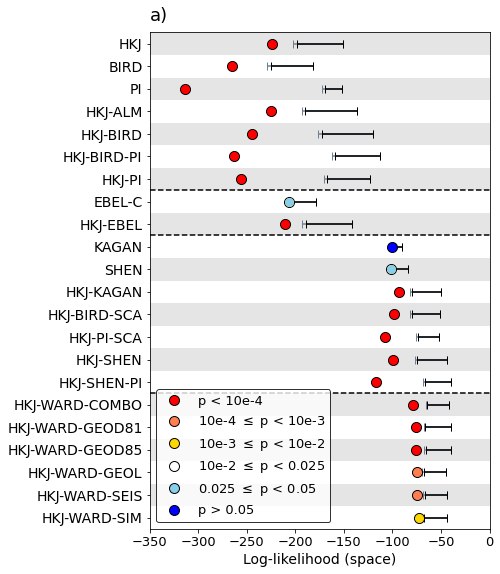

In [73]:
plt.figure()
    
S_tests = [stest_HKJ, stest_Bird, stest_PI, stest_HKJ_ALM, stest_HKJ_Bird, stest_HKJ_Bird_PI, stest_HKJ_PI, 
           stest_Ebel, stest_HKJ_Ebel, stest_Kagan, stest_Shen, stest_HKJ_Kagan, stest_HKJ_Bird_sca, 
           stest_HKJ_PI_sca, stest_HKJ_Shen, stest_HKJ_Shen_PI, stest_HKJ_Ward_combo, stest_HKJ_Ward_geod81, 
           stest_HKJ_Ward_geod85, stest_HKJ_Ward_geol, stest_HKJ_Ward_seis, stest_HKJ_Ward_sim]

ax_s = plot_poisson_consistency_test(S_tests, plot_args={'xlabel': 'Log-likelihood (space)'})

for i in range(len(S_tests)):
    plow97 = numpy.percentile(S_tests[i].test_distribution, 2.5)
    phigh97 = numpy.percentile(S_tests[i].test_distribution, 100)
    low97 = S_tests[i].observed_statistic - plow97
    high97 = phigh97 - S_tests[i].observed_statistic    
 
    ax_s.errorbar(S_tests[i].observed_statistic, 21 -i, xerr=numpy.array([[low97, high97]]).T, capsize=4, 
                  color='slategray', alpha=1.0, zorder=0)

    if S_tests[i].quantile < 10e-4:
         ax_s.plot(S_tests[i].observed_statistic, 21 - i, marker='o', color = 'red', markersize= 8, zorder=2)
    
    if S_tests[i].quantile >= 10e-4 and S_tests[i].quantile < 10e-3:
         ax_s.plot(S_tests[i].observed_statistic, 21 - i, marker='o', color = '#FF7F50', markersize= 8, zorder=2)
        
    if S_tests[i].quantile >= 10e-3 and S_tests[i].quantile < 10e-2:
         ax_s.plot(S_tests[i].observed_statistic, 21 - i, marker='o', color = 'gold', markersize= 8, zorder=2)
        
    if S_tests[i].quantile >= 10e-2 and S_tests[i].quantile < 0.025:
        ax_s.plot(S_tests[i].observed_statistic, 21 - i, marker='o', color = 'white', markersize= 8, zorder=2)
        
    if S_tests[i].quantile >= 0.025 and S_tests[i].quantile < 0.05:
        ax_s.plot(S_tests[i].observed_statistic, 21 - i, marker='o', color = 'skyblue', markersize= 8, zorder=2)    
    
    if S_tests[i].quantile > 0.05:
         ax_s.plot(S_tests[i].observed_statistic, 21 - i, marker='o', color = 'blue', markersize= 8, zorder=2)  
    
legend_elements = [Line2D([0], [0], marker='o', color='red', lw=0, label=r'p < 10e-4', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='#FF7F50', lw=0, label=r'10e-4 $\leq$ p < 10e-3', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='gold', lw=0, label=r'10e-3 $\leq$ p < 10e-2', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='white', lw=0, label=r'10e-2 $\leq$ p < 0.025', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='skyblue', lw=0, label=r'0.025 $\leq$ p < 0.05', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='blue', lw=0, label=r'p > 0.05', markersize=10, markeredgecolor='k')]

ax_s.legend(handles=legend_elements, loc=3, fontsize=13, edgecolor='k')           

ax_s.set_xlim(-350,0)
ax_s.set_title('')
ax_s.plot((-350.0, 0), (5.5, 5.5),'k--', linewidth=1.5)
ax_s.plot((-350.0, 0), (12.5, 12.5),'k--', linewidth=1.5)
ax_s.plot((-350.0, 0), (14.5, 14.5),'k--', linewidth=1.5)
ax_s.text(-350.0, 22, 'a)', fontsize =18, color='black')
#plt.savefig('Fig7a.png', dpi=200, bbox_inches = 'tight')

#### Binary S-test:

In [138]:
def binomial_joint_log_likelihood_ndarray(forecast, catalog):
    "This function compute Bernoulli log-likelihood scores, assuming that earthquakes follow a binomial distribution."
    "For this aim, we need an input variable 'forecast' and an variable'catalog'"
    
    #First, we mask the forecast in cells where we could find log=0.0 singularities:
    forecast_masked = np.ma.masked_where(forecast.ravel() == 0.0, forecast.ravel()) 
    
    #Then, we compute the log-likelihood of observing one or more events given a Poisson distribution, i.e., 1 - Pr(0) 
    target_idx = numpy.nonzero(catalog.ravel())
    y = numpy.zeros(forecast_masked.ravel().shape)
    y[target_idx[0]] = 1
    first_term = y * (np.log(1.0 - np.exp(-forecast_masked.ravel())))
    
    #Also, we estimate the log-likelihood in cells no events are observed:
    second_term = (1-y) * (-forecast_masked.ravel().data)
    #Finally, we sum both terms to compute the joint log-likelihood score:
    return sum(first_term.data + second_term.data)

In [139]:
def _binomial_likelihood_test(forecast_data, observed_data, num_simulations=1000, random_numbers=None, 
                              seed=None, use_observed_counts=True, verbose=True, normalize_likelihood=False):
    """
    Computes the likelihood-test from CSEP using an efficient simulation based approach.
    Args:
        forecast_data (numpy.ndarray): nd array where [:, -1] are the magnitude bins.
        observed_data (numpy.ndarray): same format as observation.
        num_simulations: default number of simulations to use for likelihood based simulations
        seed: used for reproducibility of the prng
        random_numbers (numpy.ndarray): can supply an explicit list of random numbers, primarily used for software testing
        use_observed_counts (bool): if true, will simulate catalogs using the observed events, if false will draw from poisson distrubtion
    """
    
    # Array-masking that avoids log singularities:
    forecast_data = numpy.ma.masked_where(forecast_data == 0.0, forecast_data) 
    
    # set seed for the likelihood test
    if seed is not None:
        numpy.random.seed(seed)

    # used to determine where simulated earthquake should be placed, by definition of cumsum these are sorted
    sampling_weights = numpy.cumsum(forecast_data.ravel()) / numpy.sum(forecast_data)

    # data structures to store results
    sim_fore = numpy.zeros(sampling_weights.shape)
    simulated_ll = []
    n_obs = len(np.unique(np.nonzero(observed_data.ravel())))
    n_fore = numpy.sum(forecast_data)
    
    
    expected_forecast_count = int(n_obs) 
    log_bin_expectations = numpy.log(forecast_data.ravel())
    
    
    if use_observed_counts and normalize_likelihood:
        scale = n_obs / n_fore
        expected_forecast_count = int(n_obs)
        log_bin_expectations = numpy.log(forecast_data.ravel() * scale)
        forecast_data = scale * forecast_data
        
    # gets the 1d indices to bins that contain target events, these indexes perform copies and not views into the array
    target_idx = numpy.nonzero(observed_data.ravel())

    # these operations perform copies
    observed_data_nonzero = observed_data.ravel()[target_idx]
    target_event_forecast = log_bin_expectations[target_idx] #* observed_data_nonzero

    
    # main simulation step in this loop
    for idx in range(num_simulations):
        if use_observed_counts:
            num_events_to_simulate = int(n_obs)
        else:
            num_events_to_simulate = int(numpy.random.poisson(expected_forecast_count))
    
        if random_numbers is None:
            sim_fore = _simulate_catalog(num_events_to_simulate, sampling_weights, sim_fore)
        else:
            sim_fore = _simulate_catalog(num_events_to_simulate, sampling_weights, sim_fore,
                                         random_numbers=random_numbers[idx,:])

        # compute joint log-likelihood from simulation by leveraging that only cells with target events contribute to likelihood
        sim_target_idx = numpy.nonzero(sim_fore)
        sim_obs_nonzero = sim_fore[sim_target_idx]
        sim_target_event_forecast = log_bin_expectations[sim_target_idx] #* sim_obs_nonzero

        # compute joint log-likelihood
        current_ll = binomial_joint_log_likelihood_ndarray(forecast_data, sim_fore)
        
        # append to list of simulated log-likelihoods
        simulated_ll.append(current_ll)

        # just be verbose
        if verbose:
            if (idx + 1) % 100 == 0:
                print(f'... {idx + 1} catalogs simulated.')
                
                target_idx = numpy.nonzero(catalog.ravel())


    # observed joint log-likelihood
    obs_ll = binomial_joint_log_likelihood_ndarray(forecast_data, observed_data)
        
    # quantile score
    qs = numpy.sum(simulated_ll <= obs_ll) / num_simulations

    # float, float, list
    return qs, obs_ll, simulated_ll

In [140]:
def spatial_test_bi(gridded_forecast, observed_catalog, num_simulations=1000, seed=None, random_numbers=None, verbose=False):
    """
    Performs the Spatial Test on the Forecast using the Observed Catalogs.
    Note: The forecast and the observations should be scaled to the same time period before calling this function. This increases
    transparency as no assumptions are being made about the length of the forecasts. This is particularly important for
    gridded forecasts that supply their forecasts as rates.
    Args:
        gridded_forecast: csep.core.forecasts.GriddedForecast
        observed_catalog: csep.core.catalogs.Catalog
        num_simulations (int): number of simulations used to compute the quantile score
        seed (int): used fore reproducibility, and testing
        random_numbers (numpy.ndarray): random numbers used to override the random number generation. injection point for testing.
    Returns:
        evaluation_result: csep.core.evaluations.EvaluationResult
    """

    # grid catalog onto spatial grid
    gridded_catalog_data = observed_catalog.spatial_counts()

    # simply call likelihood test on catalog data and forecast
    qs, obs_ll, simulated_ll = _binomial_likelihood_test(gridded_forecast.spatial_counts(), gridded_catalog_data,
                                                        num_simulations=num_simulations,
                                                        seed=seed,
                                                        random_numbers=random_numbers,
                                                        use_observed_counts=True,
                                                        verbose=verbose, normalize_likelihood=True)

    
# populate result data structure
    result = EvaluationResult()
    result.test_distribution = simulated_ll
    result.name = 'Binary S-Test'
    result.observed_statistic = obs_ll
    result.quantile = qs
    result.sim_name = gridded_forecast.name
    result.obs_name = observed_catalog.name
    result.status = 'normal'
    try:
        result.min_mw = numpy.min(gridded_forecast.magnitudes)
    except AttributeError:
        result.min_mw = -1
    return result    

In [142]:
# Spatial-tests for earthquake forecasts in California
stest_HKJ_bi = spatial_test_bi(HKJ_f, catalog_Cali2, seed=seed)
stest_Bird_bi = spatial_test_bi(Bird_f, catalog_Cali2, seed=seed)
stest_PI_bi = spatial_test_bi(PI_f, catalog_Cali2, seed=seed)
stest_HKJ_ALM_bi = spatial_test_bi(HKJ_ALMf, catalog_Cali2, seed=seed)
stest_HKJ_Bird_bi = spatial_test_bi(HKJ_Birdf, catalog_Cali2, seed=seed)
stest_HKJ_Bird_PI_bi = spatial_test_bi(HKJ_Bird_PIf, catalog_Cali2, seed=seed)
stest_HKJ_PI_bi = spatial_test_bi(HKJ_PIf, catalog_Cali2, seed=seed)
stest_Ebel_bi = spatial_test_bi(Ebel_cf, catalog_Ebel, seed=seed)
stest_HKJ_Ebel_bi = spatial_test_bi(HKJ_Ebelf, catalog_Ebel, seed=seed)

# Spatial-tests for earthquake forecasts in southern California:
stest_Kagan_bi = spatial_test_bi(Kagan_f, catalog_Kagan, seed=seed)
stest_Shen_bi = spatial_test_bi(Shen_f, catalog_Shen, seed=seed)
stest_HKJ_Kagan_bi = spatial_test_bi(HKJ_Kaganf, catalog_HKJ_Kagan, seed=seed)
stest_HKJ_Bird_sca_bi = spatial_test_bi(HKJ_Bird_scaf, catalog_Shen, seed=seed)
stest_HKJ_PI_sca_bi = spatial_test_bi(HKJ_PI_scaf, catalog_Shen, seed=seed)
stest_HKJ_Shen_bi = spatial_test_bi(HKJ_Shenf, catalog_Shen, seed=seed)
stest_HKJ_Shen_PI_bi = spatial_test_bi(HKJ_Shen_PIf, catalog_Shen, seed=seed)
stest_HKJ_Ward_combo_bi = spatial_test_bi(HKJ_Ward_combof, catalog_Ward, seed=seed)
stest_HKJ_Ward_geod81_bi = spatial_test_bi(HKJ_Ward_geod81f, catalog_Ward, seed=seed)
stest_HKJ_Ward_geod85_bi = spatial_test_bi(HKJ_Ward_geod85f, catalog_Ward, seed=seed)
stest_HKJ_Ward_geol_bi = spatial_test_bi(HKJ_Ward_geolf, catalog_Ward, seed=seed)
stest_HKJ_Ward_seis_bi = spatial_test_bi(HKJ_Ward_seisf, catalog_Ward)
stest_HKJ_Ward_sim_bi = spatial_test_bi(HKJ_Ward_simf, catalog_Ward)

/tmp/ipykernel_25787/3779499490.py:32: RuntimeWarning: divide by zero encountered in log
  log_bin_expectations = numpy.log(forecast_data.ravel())
/tmp/ipykernel_25787/3779499490.py:38: RuntimeWarning: divide by zero encountered in log
  log_bin_expectations = numpy.log(forecast_data.ravel() * scale)


Text(-350.0, 22, 'b)')

<Figure size 432x288 with 0 Axes>

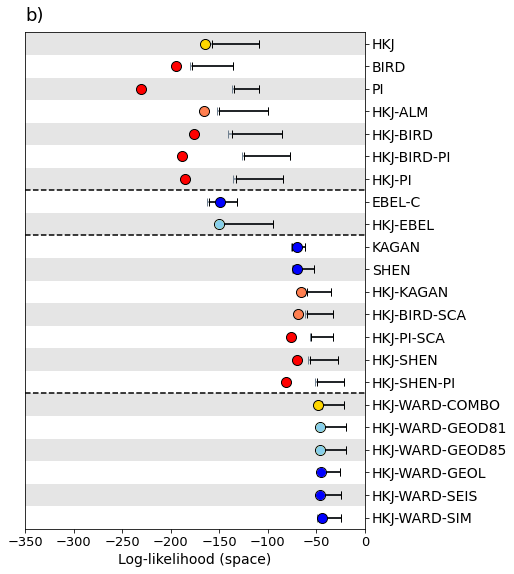

In [145]:
plt.figure()

S_tests_bi = [stest_HKJ_bi, stest_Bird_bi, stest_PI_bi, stest_HKJ_ALM_bi, stest_HKJ_Bird_bi, stest_HKJ_Bird_PI_bi, 
              stest_HKJ_PI_bi, stest_Ebel_bi, stest_HKJ_Ebel_bi, stest_Kagan_bi, stest_Shen_bi, stest_HKJ_Kagan_bi, 
              stest_HKJ_Bird_sca_bi, stest_HKJ_PI_sca_bi, stest_HKJ_Shen_bi, stest_HKJ_Shen_PI_bi, 
              stest_HKJ_Ward_combo_bi, stest_HKJ_Ward_geod81_bi, stest_HKJ_Ward_geod85_bi, stest_HKJ_Ward_geol_bi,
              stest_HKJ_Ward_seis_bi, stest_HKJ_Ward_sim_bi]


ax_s = plot_poisson_consistency_test(S_tests_bi, plot_args={'xlabel': 'Log-likelihood (space)'})

for i in range(len(S_tests_bi)):
    plow97 = numpy.percentile(S_tests_bi[i].test_distribution, 2.5)
    phigh97 = numpy.percentile(S_tests_bi[i].test_distribution, 100)
    low97 = S_tests_bi[i].observed_statistic - plow97
    high97 = phigh97 - S_tests_bi[i].observed_statistic    
 
    ax_s.errorbar(S_tests_bi[i].observed_statistic, 21 -i, xerr=numpy.array([[low97, high97]]).T, capsize=4, 
                  color='slategray', alpha=1.0, zorder=0)
        
    if S_tests_bi[i].quantile < 10e-4:
         ax_s.plot(S_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'red', markersize= 8, zorder=2)
    
    if S_tests_bi[i].quantile >= 10e-4 and S_tests_bi[i].quantile < 10e-3:
         ax_s.plot(S_tests_bi[i].observed_statistic, 21 - i, marker='o', color = '#FF7F50', markersize= 8, zorder=2)
        
    if S_tests_bi[i].quantile >= 10e-3 and S_tests_bi[i].quantile < 10e-2:
         ax_s.plot(S_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'gold', markersize= 8, zorder=2)
        
    if S_tests_bi[i].quantile >= 10e-2 and S_tests_bi[i].quantile < 0.025:
        ax_s.plot(S_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'white', markersize= 8, zorder=2)
        
    if S_tests_bi[i].quantile >= 0.025 and S_tests_bi[i].quantile < 0.05:
        ax_s.plot(S_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'skyblue', markersize= 8, zorder=2)    
    
    if S_tests_bi[i].quantile > 0.05:
         ax_s.plot(S_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'blue', markersize= 8, zorder=2)      


ax_s.yaxis.tick_right()  
ax_s.set_xlim(-350,0)
ax_s.set_title('')
ax_s.plot((-350.0, 0), (5.5, 5.5),'k--', linewidth=1.5)
ax_s.plot((-350.0, 0), (12.5, 12.5),'k--', linewidth=1.5)
ax_s.plot((-350.0, 0), (14.5, 14.5),'k--', linewidth=1.5)
ax_s.text(-350.0, 22, 'b)', fontsize =18, color='black')
#plt.savefig('Fig7b.png', dpi=100, bbox_inches = 'tight')

#### Fig. 7: Results of tjhe one-sided S test for forecasts in California based on a) a Poisson and b) a binary likelihood function. Symbols depict observed joint (spatial) log-likelihood scores and the colors denote p-values calculated for each forecasting model. blue colors indicate consistencies between forecasts and the observations and red-orange colors indicate the opposite. Solid horizontal black and gray bars represent the 95% and 97.5% predictive intervals of the model forecast forecast probability distributions.

In [71]:
def poisson_spatial_likelihood(forecast, catalog):
    'This function computes the observed log-likehood score obtained by a gridded forecast in each cell, given a'
    'seismicity catalog. In this case, we assume a Poisson distribution of earthquakes, so that the likelihood of'
    'observing an event w given the expected value x in each cell is:'
    'poll = -x + wlnx - ln(w!)'
    
    'Arguments:'
    'forecast: gridded forecast'
    'catalog: observed catalog'
    
    'Returns:'
    'poll: Poisson-based log-likelihood scores obtained by the forecast in each spatial cell.'
    
    'Notes:'
    'log(w!) = 0'
    'factorial(n) = loggamma(n+1)'
    
    scale = catalog.event_count / forecast.event_count
    
    first_term = -forecast.spatial_counts() * scale
    second_term = catalog.spatial_counts() * np.log(forecast.spatial_counts() * scale)
    third_term = -scipy.special.loggamma(catalog.spatial_counts() + 1)
    
    poll = first_term + second_term + third_term
    
    return poll

In [72]:
POLL_HKJ = poisson_spatial_likelihood(HKJ_f, catalog_Cali2)

In [94]:
def plot_spatial_likelihood(forecast, catalog, LL, markersizem, marker_sizeLL):
    'This function plots the spatial distribution of log-likehood scores obtained by an earthquake forecast,' 
    'given an observed catalog.'
    
    'Arguments:'
    'forecast: gridded forecast.'
    'catalog: observed catalog'
    'LL: array containing log-likelihood scores, computed in each grid cell.'
    'marker_sizem: numerical value controlling the size of the earthquake markers according to magnitude.'
    'In this example, a value of 3.5 is used.'
    'marker_sizeLL: numerical value controlling the size of log-likelihood markers. In this case study,'
    'a value of -3 is employed.'
    
    # We define some plot parameters for the figure:
    ax_sl = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax_sl.add_feature(cartopy.feature.STATES, zorder=1)
    ax_sl.add_image(_get_basemap('ESRI_imagery'), 6)
    ax_sl.set_facecolor('lightgrey')
    dh = round(forecast.region.dh, 5)
    gl = ax_sl.gridlines(draw_labels=True, alpha=0)
    gl.xlines = False
    gl.ylines = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    
    ax_sl.set_xlim(min(forecast.get_longitudes())-0.1+dh/2, max(forecast.get_longitudes())+0.1+dh/2)
    ax_sl.set_ylim(min(forecast.get_latitudes())-0.1+dh/2, max(forecast.get_latitudes())+0.1+dh/2)
     
    
    # We highlight the testing area for visualitazion purposes:
    scatter_LL1 = ax_sl.scatter(forecast.get_longitudes()+ dh/2, forecast.get_latitudes()+dh/2, 
                           c='grey', s= 49, marker='s', alpha=0.2, zorder=1)
    
    # Here, we sort the catalog to plot earthquakes according to magnitudes:
    catalog_s = np.sort(catalog.data, order=['magnitude']) 
    
    # We plot the earthquake catalog:
    scatter_e = ax_sl.scatter(catalog_s['longitude'], catalog_s['latitude'], 
                              s = markersizem*2**(catalog_s['magnitude']), 
                edgecolors= 'white', vmin = min(catalog_s['magnitude']), facecolor="None",
                vmax = max(catalog_s['magnitude']), alpha =1, linewidth=1, marker='s', zorder=2)
    
    handles, labels = scatter_e.legend_elements(prop="sizes", num=4, markerfacecolor="None", 
                                              markeredgecolor='white', alpha=1, linewidth=1, zorder=2)

    
    mags_range = [f'{round(min(catalog.get_magnitudes()),0)}',
                  f'{(round(min(catalog.get_magnitudes()),0) + round(max(catalog.get_magnitudes()),0))/2}',
                  f'{round(max(catalog.get_magnitudes()),0)}']
    legend2 = ax_sl.legend(handles, mags_range, loc="upper right", 
                            edgecolor='black', labelspacing=1, framealpha=1, fontsize=14, facecolor='darkgrey')
 
    legend2.set_title('Magnitude',prop={'size':'x-large'}) 
    
    # Finally, we plot the log-likelihood scores:
    scatter_LL = ax_sl.scatter(forecast.get_longitudes()+ dh/2, forecast.get_latitudes()+ dh/2, 
                           c= LL, cmap='autumn', s= -3 * LL, vmin=-30, vmax=0, marker='s', alpha=0.7, zorder=2)        
    
    
    cax = fig.add_axes([ax_sl.get_position().x1 + 0.01, ax_sl.get_position().y0, 0.025, ax_sl.get_position().height])
    cbar = fig.colorbar(scatter_LL, cax=cax)
    cbar.set_label('Log-likelihood score (space)', fontsize=15)
    cbar.ax.tick_params(labelsize='x-large')
    
    return ax_sl

Text(-126.0, 43.5, 'a)')

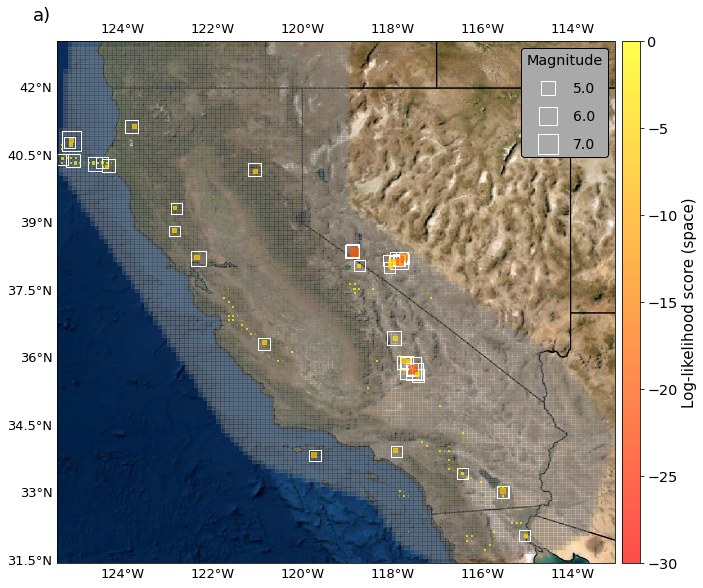

In [95]:
fig = plt.figure(figsize=(10,20))
ax_POLL_HKJ = plot_spatial_likelihood(HKJ_f, catalog_Cali2, POLL_HKJ, 3.5, -3)
ax_POLL_HKJ.text(-126.0, 43.5, 'a)', fontsize =18, color='black')
plt.savefig('Fig8a.png', dpi=100, bbox_inches = 'tight')

In [96]:
def _binary_spatial_likelihood(forecast, catalog):
    "This function computes log-likelihood scores (BILLs), using a binary likelihood distribution of earthquakes."
    "For this aim, we need an input variable 'forecast' and an variable'catalog'"
    
    'This function computes the observed log-likehood score obtained by a gridded forecast in each cell, given a'
    'seismicity catalog. In this case, we assume a binary distribution of earthquakes, so that the likelihood of'
    'observing an event w given the expected value x in each cell is:'
    'BILL = (1-X) * ln(exp(-λ)) + X * ln(1 - exp(-λ)), with X=1 if earthquake and X=0 if no earthquake.'
    
    'Arguments:'
    'forecast: gridded forecast'
    'catalog: observed catalog'
    
    'Returns:'
    'BILL: Binary-based log-likelihood scores obtained by the forecast in each spatial cell.'
    'joint_BILL: Observed joint (spatial) likelihood score obtained by the forecast.'
    
    scale = catalog.event_count / forecast.event_count
    target_idx = numpy.nonzero(catalog.spatial_counts())
    X = numpy.zeros(forecast.spatial_counts().shape)
    X[target_idx[0]] = 1
    
    #First, we estimate the log-likelihood in cells where no events are observed:
    first_term = (1-X) * (-forecast.spatial_counts() * scale)
    
    #Then, we compute the log-likelihood of observing one or more events given a Poisson distribution, 
    #i.e., 1 - Pr(0):
    second_term = X * (np.log(1.0 - np.exp(-forecast.spatial_counts() * scale)))
    
    #Finally, we sum both terms to compute log-likelihood score in each spatial cell:
    bill = first_term + second_term

    joint_BILL = sum(bill)
    
    return bill

In [97]:
BILL_HKJ = _binary_spatial_likelihood(HKJ_f, catalog_Cali2)

Text(-126.0, 43.5, 'b)')

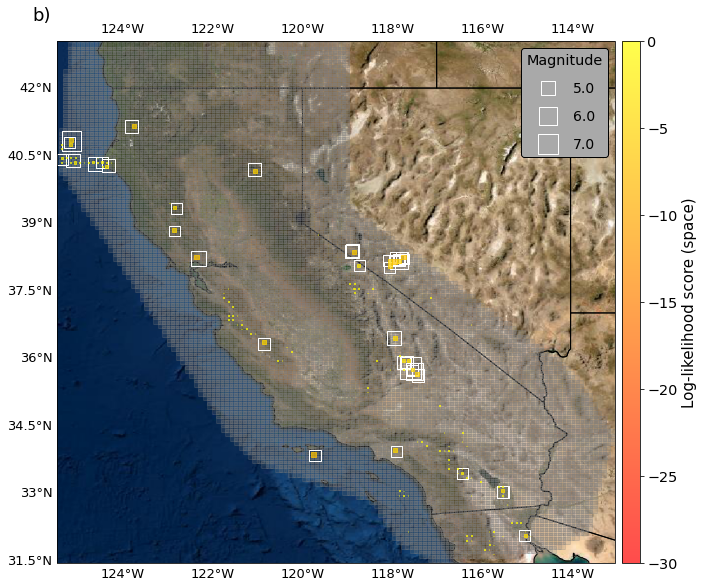

In [98]:
fig = plt.figure(figsize=(10,20))
ax_BILL_HKJ = plot_spatial_likelihood(HKJ_f, catalog_Cali2, BILL_HKJ, 3.5, -3)
ax_BILL_HKJ.text(-126.0, 43.5, 'b)', fontsize =18, color='black')
#plt.savefig('Fig8b.png', dpi=100, bbox_inches = 'tight')

#### Fig. 8: Spatial distribution of log-likelihood scores obtained in each spatial cell by the HKJ forecast, using a) a Poisson and b) a binary likelihood function. The Poisson-based S-test penalises the model for the unlikely occurrence of the 2016 Hawthorne earthquake swarm (zoomed in) and the 2019 Ridgecrest sequence in a few spatial cells more severely than the S-test that relies on a binary probability function. White squares denote the epicentral locations of the M$\geq$4.95 target earthquakes.

### cL-TESTS:

Poisson cL-test:

In [146]:
# Likelihood-tests for earthquake forecasts in California:
cltest_HKJ = poisson.conditional_likelihood_test(HKJ_f, catalog_Cali2, seed=seed)
cltest_Bird = poisson.conditional_likelihood_test(Bird_f, catalog_Cali2, seed=seed)
cltest_PI = poisson.conditional_likelihood_test(PI_f, catalog_Cali2, seed=seed)
cltest_HKJ_ALM = poisson.conditional_likelihood_test(HKJ_ALMf, catalog_Cali2, seed=seed)
cltest_HKJ_Bird = poisson.conditional_likelihood_test(HKJ_Birdf, catalog_Cali2, seed=seed)
cltest_HKJ_Bird_PI = poisson.conditional_likelihood_test(HKJ_Bird_PIf, catalog_Cali2, seed=seed)
cltest_HKJ_PI = poisson.conditional_likelihood_test(HKJ_PIf, catalog_Cali2, seed=seed)
cltest_Ebel = poisson.conditional_likelihood_test(Ebel_cf, catalog_Ebel, seed=seed)
cltest_HKJ_Ebel = poisson.conditional_likelihood_test(HKJ_Ebelf, catalog_Ebel, seed=seed)

# Likelihood-tests for earthquake forecasts in southern California:
cltest_Kagan = poisson.conditional_likelihood_test(Kagan_f, catalog_Kagan, seed=seed)
cltest_Shen = poisson.conditional_likelihood_test(Shen_f, catalog_Shen, seed=seed)
cltest_HKJ_Kagan = poisson.conditional_likelihood_test(HKJ_Kaganf, catalog_HKJ_Kagan, seed=seed)
cltest_HKJ_Bird_sca = poisson.conditional_likelihood_test(HKJ_Bird_scaf, catalog_Shen, seed=seed)
cltest_HKJ_PI_sca = poisson.conditional_likelihood_test(HKJ_PI_scaf, catalog_Shen, seed=seed)
cltest_HKJ_Shen = poisson.conditional_likelihood_test(HKJ_Shenf, catalog_Shen, seed=seed)
cltest_HKJ_Shen_PI = poisson.conditional_likelihood_test(HKJ_Shen_PIf, catalog_Shen, seed=seed)
cltest_HKJ_Ward_combo = poisson.conditional_likelihood_test(HKJ_Ward_combof, catalog_Ward, seed=seed)
cltest_HKJ_Ward_geod81 = poisson.conditional_likelihood_test(HKJ_Ward_geod81f, catalog_Ward, seed=seed)
cltest_HKJ_Ward_geod85 = poisson.conditional_likelihood_test(HKJ_Ward_geod85f, catalog_Ward, seed=seed)
cltest_HKJ_Ward_geol = poisson.conditional_likelihood_test(HKJ_Ward_geolf, catalog_Ward, seed=seed)
cltest_HKJ_Ward_seis = poisson.conditional_likelihood_test(HKJ_Ward_seisf, catalog_Ward, seed=seed)
cltest_HKJ_Ward_sim = poisson.conditional_likelihood_test(HKJ_Ward_simf, catalog_Ward, seed=seed)

/home/tono/anaconda3/envs/gji-hybrids/lib/python3.10/site-packages/csep/core/poisson_evaluations.py:595: RuntimeWarning: divide by zero encountered in log
  log_bin_expectations = numpy.log(forecast_data.ravel())


Text(-500.0, 22, 'a)')

<Figure size 432x288 with 0 Axes>

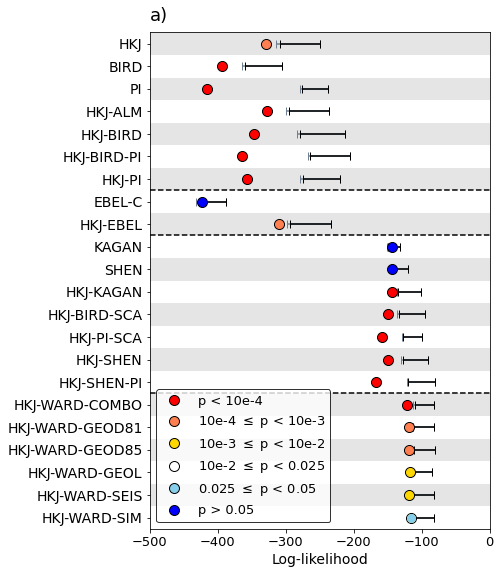

In [148]:
plt.figure()

cl_tests = [cltest_HKJ, cltest_Bird, cltest_PI, cltest_HKJ_ALM, cltest_HKJ_Bird, cltest_HKJ_Bird_PI, 
            cltest_HKJ_PI, cltest_Ebel, cltest_HKJ_Ebel, cltest_Kagan, cltest_Shen, cltest_HKJ_Kagan, 
            cltest_HKJ_Bird_sca, cltest_HKJ_PI_sca, cltest_HKJ_Shen, cltest_HKJ_Shen_PI, cltest_HKJ_Ward_combo, 
            cltest_HKJ_Ward_geod81, cltest_HKJ_Ward_geod85, cltest_HKJ_Ward_geol,
            cltest_HKJ_Ward_seis, cltest_HKJ_Ward_sim]

ax_cl = plot_poisson_consistency_test(cl_tests, plot_args={'xlabel': 'Log-likelihood'})

for i in range(len(cl_tests)):
    plow97 = numpy.percentile(cl_tests[i].test_distribution, 2.5)
    phigh97 = numpy.percentile(cl_tests[i].test_distribution, 100)
    low97 = cl_tests[i].observed_statistic - plow97
    high97 = phigh97 - cl_tests[i].observed_statistic    
 
    ax_cl.errorbar(cl_tests[i].observed_statistic, 21 -i, xerr=numpy.array([[low97, high97]]).T, capsize=4, 
                  color='slategray', alpha=1.0, zorder=0) 
        
    if cl_tests[i].quantile < 10e-4:
         ax_cl.plot(cl_tests[i].observed_statistic, 21 - i, marker='o', color = 'red', markersize= 8, zorder=2)
    
    if cl_tests[i].quantile >= 10e-4 and cl_tests[i].quantile < 10e-3:
         ax_cl.plot(cl_tests[i].observed_statistic, 21 - i, marker='o', color = '#FF7F50', markersize= 8, zorder=2)
        
    if cl_tests[i].quantile >= 10e-3 and cl_tests[i].quantile < 10e-2:
         ax_cl.plot(cl_tests[i].observed_statistic, 21 - i, marker='o', color = 'gold', markersize= 8, zorder=2)
        
    if cl_tests[i].quantile >= 10e-2 and cl_tests[i].quantile < 0.025:
        ax_cl.plot(cl_tests[i].observed_statistic, 21 - i, marker='o', color = 'white', markersize= 8, zorder=2)
        
    if cl_tests[i].quantile >= 0.025 and cl_tests[i].quantile < 0.05:
        ax_cl.plot(cl_tests[i].observed_statistic, 21 - i, marker='o', color = 'skyblue', markersize= 8, zorder=2)    
    
    if cl_tests[i].quantile > 0.05:
         ax_cl.plot(cl_tests[i].observed_statistic, 21 - i, marker='o', color = 'blue', markersize= 8, zorder=2)     


legend_elements = [Line2D([0], [0], marker='o', color='red', lw=0, label=r'p < 10e-4', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='#FF7F50', lw=0, label=r'10e-4 $\leq$ p < 10e-3', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='gold', lw=0, label=r'10e-3 $\leq$ p < 10e-2', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='white', lw=0, label=r'10e-2 $\leq$ p < 0.025', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='skyblue', lw=0, label=r'0.025 $\leq$ p < 0.05', markersize=10, markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='blue', lw=0, label=r'p > 0.05', markersize=10, markeredgecolor='k')]

ax_cl.legend(handles=legend_elements, loc=3, fontsize=13, edgecolor='k')          
  
    
ax_cl.set_xlim(-500,0)
ax_cl.set_title('')
ax_cl.plot((-500.0, 0), (5.5, 5.5),'k--', linewidth=1.5)
ax_cl.plot((-500.0, 0), (12.5, 12.5),'k--', linewidth=1.5)
ax_cl.plot((-500.0, 0), (14.5, 14.5),'k--', linewidth=1.5)
ax_cl.text(-500.0, 22, 'a)', fontsize =18, color='black')
plt.savefig('Fig9a.png', dpi=100, bbox_inches = 'tight')

Binary cL-test:

In [149]:
def conditional_likelihood_test_bi(gridded_forecast, observed_catalog, num_simulations=1000, seed=None, random_numbers=None, verbose=False):    
    """Performs the conditional likelihood test on Gridded Forecast using an Observed Catalog.

    This test normalizes the forecast so the forecasted rate are consistent with the observations. This modification
    eliminates the strong impact differences in the number distribution have on the forecasted rates.

    Note: The forecast and the observations should be scaled to the same time period before calling this function. This increases
    transparency as no assumptions are being made about the length of the forecasts. This is particularly important for
    gridded forecasts that supply their forecasts as rates.

    Args:
        gridded_forecast: csep.core.forecasts.GriddedForecast
        observed_catalog: csep.core.catalogs.Catalog
        num_simulations (int): number of simulations used to compute the quantile score
        seed (int): used fore reproducibility, and testing
        random_numbers (numpy.ndarray): random numbers used to override the random number generation. injection point for testing.

    Returns:
        evaluation_result: csep.core.evaluations.EvaluationResult
    """
        
    # grid catalog onto spatial grid
    gridded_catalog_data = observed_catalog.spatial_magnitude_counts()

    # simply call likelihood test on catalog data and forecast
    qs, obs_ll, simulated_ll = _binomial_likelihood_test(gridded_forecast.data, gridded_catalog_data,
                                                        num_simulations=num_simulations, seed=seed, random_numbers=random_numbers,
                                                        use_observed_counts=True,
                                                        verbose=verbose, normalize_likelihood=False)

    # populate result data structure
    result = EvaluationResult()
    result.test_distribution = simulated_ll
    result.name = 'Binary CL-Test'
    result.observed_statistic = obs_ll
    result.quantile = qs
    result.sim_name = gridded_forecast.name
    result.obs_name = observed_catalog.name
    result.status = 'normal'
    result.min_mw = numpy.min(gridded_forecast.magnitudes)

    return result

In [150]:
#Conditional-likelihood-tests for earthquake forecasts in California
cltest_HKJ_bi = conditional_likelihood_test_bi(HKJ_f, catalog_Cali2, seed=seed)
cltest_Bird_bi = conditional_likelihood_test_bi(Bird_f, catalog_Cali2, seed=seed)
cltest_PI_bi = conditional_likelihood_test_bi(PI_f, catalog_Cali2, seed=seed)
cltest_HKJ_ALM_bi = conditional_likelihood_test_bi(HKJ_ALMf, catalog_Cali2, seed=seed)
cltest_HKJ_Bird_bi = conditional_likelihood_test_bi(HKJ_Birdf, catalog_Cali2, seed=seed)
cltest_HKJ_Bird_PI_bi = conditional_likelihood_test_bi(HKJ_Bird_PIf, catalog_Cali2, seed=seed)
cltest_HKJ_PI_bi = conditional_likelihood_test_bi(HKJ_PIf, catalog_Cali2, seed=seed)
cltest_Ebel_bi = conditional_likelihood_test_bi(Ebel_cf, catalog_Ebel, seed=seed)
cltest_HKJ_Ebel_bi = conditional_likelihood_test_bi(HKJ_Ebelf, catalog_Ebel, seed=seed)

#Conditional-likelihood-tests for earthquake forecasts in southern California:
cltest_Kagan_bi = conditional_likelihood_test_bi(Kagan_f, catalog_Kagan, seed=seed)
cltest_Shen_bi = conditional_likelihood_test_bi(Shen_f, catalog_Shen, seed=seed)
cltest_HKJ_Kagan_bi = conditional_likelihood_test_bi(HKJ_Kaganf, catalog_HKJ_Kagan, seed=seed)
cltest_HKJ_Bird_sca_bi = conditional_likelihood_test_bi(HKJ_Bird_scaf, catalog_Shen, seed=seed)
cltest_HKJ_PI_sca_bi = conditional_likelihood_test_bi(HKJ_PI_scaf, catalog_Shen, seed=seed)
cltest_HKJ_Shen_bi = conditional_likelihood_test_bi(HKJ_Shenf, catalog_Shen, seed=seed)
cltest_HKJ_Shen_PI_bi = conditional_likelihood_test_bi(HKJ_Shen_PIf, catalog_Shen, seed=seed)
cltest_HKJ_Ward_combo_bi = conditional_likelihood_test_bi(HKJ_Ward_combof, catalog_Ward, seed=seed)
cltest_HKJ_Ward_geod81_bi = conditional_likelihood_test_bi(HKJ_Ward_geod81f, catalog_Ward, seed=seed)
cltest_HKJ_Ward_geod85_bi = conditional_likelihood_test_bi(HKJ_Ward_geod85f, catalog_Ward, seed=seed)
cltest_HKJ_Ward_geol_bi = conditional_likelihood_test_bi(HKJ_Ward_geolf, catalog_Ward, seed=seed)
cltest_HKJ_Ward_seis_bi = conditional_likelihood_test_bi(HKJ_Ward_seisf, catalog_Ward, seed=seed)
cltest_HKJ_Ward_sim_bi = conditional_likelihood_test_bi(HKJ_Ward_simf, catalog_Ward, seed=seed)

/tmp/ipykernel_25787/465025176.py:12: RuntimeWarning: divide by zero encountered in log
  first_term = y * (np.log(1.0 - np.exp(-forecast_masked.ravel())))
/tmp/ipykernel_25787/3779499490.py:32: RuntimeWarning: divide by zero encountered in log
  log_bin_expectations = numpy.log(forecast_data.ravel())


Text(-500.0, 22, 'b)')

<Figure size 432x288 with 0 Axes>

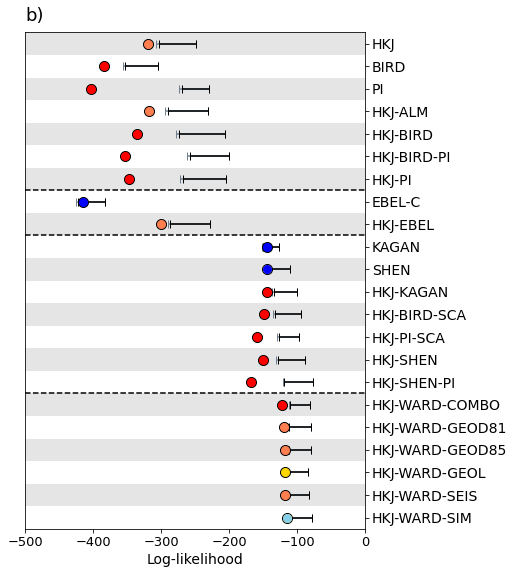

In [151]:
plt.figure()

cl_tests_bi = [cltest_HKJ_bi, cltest_Bird_bi, cltest_PI_bi, cltest_HKJ_ALM_bi, cltest_HKJ_Bird_bi,
                                      cltest_HKJ_Bird_PI_bi, cltest_HKJ_PI_bi, cltest_Ebel_bi, cltest_HKJ_Ebel_bi, cltest_Kagan_bi,
                                      cltest_Shen_bi, cltest_HKJ_Kagan_bi, cltest_HKJ_Bird_sca_bi, cltest_HKJ_PI_sca_bi,
                                      cltest_HKJ_Shen_bi, cltest_HKJ_Shen_PI_bi, cltest_HKJ_Ward_combo_bi, 
                                      cltest_HKJ_Ward_geod81_bi, cltest_HKJ_Ward_geod85_bi, cltest_HKJ_Ward_geol_bi,
                                      cltest_HKJ_Ward_seis_bi, cltest_HKJ_Ward_sim_bi]

ax_cl = plot_poisson_consistency_test(cl_tests_bi, plot_args={'xlabel': 'Log-likelihood'})

for i in range(len(cl_tests_bi)):
    plow97 = numpy.percentile(cl_tests_bi[i].test_distribution, 2.5)
    phigh97 = numpy.percentile(cl_tests_bi[i].test_distribution, 100)
    low97 = cl_tests_bi[i].observed_statistic - plow97
    high97 = phigh97 - cl_tests_bi[i].observed_statistic    
 
    ax_cl.errorbar(cl_tests_bi[i].observed_statistic, 21 -i, xerr=numpy.array([[low97, high97]]).T, capsize=4, 
                  color='slategray', alpha=1.0, zorder=0) 
    
    if cl_tests_bi[i].quantile < 10e-4:
         ax_cl.plot(cl_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'red', markersize= 8, zorder=2)
    
    if cl_tests_bi[i].quantile >= 10e-4 and cl_tests_bi[i].quantile < 10e-3:
         ax_cl.plot(cl_tests_bi[i].observed_statistic, 21 - i, marker='o', color = '#FF7F50', markersize= 8, zorder=2)
        
    if cl_tests_bi[i].quantile >= 10e-3 and cl_tests_bi[i].quantile < 10e-2:
         ax_cl.plot(cl_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'gold', markersize= 8, zorder=2)
        
    if cl_tests_bi[i].quantile >= 10e-2 and cl_tests_bi[i].quantile < 0.025:
        ax_cl.plot(cl_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'white', markersize= 8, zorder=2)
        
    if cl_tests_bi[i].quantile >= 0.025 and cl_tests_bi[i].quantile < 0.05:
        ax_cl.plot(cl_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'skyblue', markersize= 8, zorder=2)    
    
    if cl_tests_bi[i].quantile > 0.05:
         ax_cl.plot(cl_tests_bi[i].observed_statistic, 21 - i, marker='o', color = 'blue', markersize= 8, zorder=2)
    

ax_cl.yaxis.tick_right()
ax_cl.set_xlim(-500,0)
ax_cl.set_title('')
ax_cl.plot((-500.0, 0), (5.5, 5.5),'k--', linewidth=1.5)
ax_cl.plot((-500.0, 0), (12.5, 12.5),'k--', linewidth=1.5)
ax_cl.plot((-500.0, 0), (14.5, 14.5),'k--', linewidth=1.5)
ax_cl.text(-500.0, 22, 'b)', fontsize =18, color='black')
#plt.savefig('Fig9b.png', dpi=100, bbox_inches = 'tight')

#### Fig. 9: cL-test results for forecasts in California based on a) a Poisson and b) a binary probability function. The circles denote observed joint (space-magnitude) log-likelihood scores and colors represent the p-values calculated for the forecasting models. blue colors indicate consistencies between the forecasts and the observatiosn and red-orange colors denote the opposite. Solid horizontal black anf gray bars represent the 95% and 97.5% predictive ranges of the model forecast likelihood distributions. Discrepancies between Poisson and binary cL-test results for forecasting models in the whole of California are negligible, because the evaluation period contains 40 earthquakes that fell into 39 space-magnitude bins. For models in southern California, the differences between Poisson and binary cL-test results are even smaller, as the number of observed earthquakes equals the number of active bins.

### Comparative T tests:

In [99]:
def _t_test_ndarray(target_event_rates1, target_event_rates2, n_obs, n_f1, n_f2, alpha=0.05):
    """ Computes T test statistic by comparing two target event rate distributions.

    We compare Forecast from Model 1 and with Forecast of Model 2. Information Gain is computed, which is then employed
    to compute T statistic. Confidence interval of Information Gain can be computed using T_critical. For a complete explanation
    see Rhoades, D. A., et al., (2011). Efficient testing of earthquake forecasting models. Acta Geophysica, 59(4), 728-747.
    doi:10.2478/s11600-011-0013-5

    Args:
        target_event_rates1 (numpy.ndarray): nd-array storing target event rates
        target_event_rates2 (numpy.ndarray): nd-array storing target event rates
        n_obs (float, int, numpy.ndarray): number of observed earthquakes, should be whole number and >= zero.
        alpha (float): tolerance level for the type-i error rate of the statistical test

    Returns:
        out (dict): relevant statistics from the t-test

    """
    # Some Pre Calculations -  Because they are being used repeatedly.
    N = n_obs  # Total number of observed earthquakes
    N1 = n_f1  # Total number of forecasted earthquakes by Model 1
    N2 = n_f2  # Total number of forecasted earthquakes by Model 2
    X1 = numpy.log(target_event_rates1)  # Log of every element of Forecast 1
    X2 = numpy.log(target_event_rates2)  # Log of every element of Forecast 2

    # Information Gain, using Equation (17)  of Rhoades et al. 2011
    information_gain = (numpy.sum(X1 - X2) - (N1 - N2)) / N

    # Compute variance of (X1-X2) using Equation (18)  of Rhoades et al. 2011
    first_term = (numpy.sum(numpy.power((X1 - X2), 2))) / (N - 1)
    second_term = numpy.power(numpy.sum(X1 - X2), 2) / (numpy.power(N, 2) - N)
    forecast_variance = first_term - second_term

    forecast_std = numpy.sqrt(forecast_variance)
    t_statistic = information_gain / (forecast_std / numpy.sqrt(N))

    # Obtaining the Critical Value of T from T distribution.
    df = N - 1
    t_critical = scipy.stats.t.ppf(1 - (alpha / 2), df)  # Assuming 2-Tail Distribution  for 2 tail, divide 0.05/2.

    # Computing Information Gain Interval.
    ig_lower = information_gain - (t_critical * forecast_std / numpy.sqrt(N))
    ig_upper = information_gain + (t_critical * forecast_std / numpy.sqrt(N))

    # If T value greater than T critical, Then both Lower and Upper Confidence Interval limits will be greater than Zero.
    # If above Happens, Then It means that Forecasting Model 1 is better than Forecasting Model 2.
    return {'t_statistic': t_statistic,
            't_critical': t_critical,
            'information_gain': information_gain,
            'ig_lower': ig_lower,
            'ig_upper': ig_upper}

### Poisson T-test:

In [103]:
# Comparative T-tests between earthquake forecasts in California:
ttest_Bird_HKJ = poisson.paired_t_test(Bird_f, HKJ_f, catalog_Cali2)
ttest_PI_HKJ = poisson.paired_t_test(PI_PIf, HKJ_inPIf, catalog_CaliP2)
ttest_HKJ_ALM_HKJ = poisson.paired_t_test(HKJ_ALMf, HKJ_f, catalog_Cali2)
ttest_HKJ_Bird_HKJ = poisson.paired_t_test(HKJ_Birdf, HKJ_f, catalog_Cali2)
ttest_HKJ_Bird_PI_HKJ = poisson.paired_t_test(HKJ_Bird_PIf, HKJ_f, catalog_Cali2)
ttest_HKJ_PI_HKJ = poisson.paired_t_test(HKJ_PIf, HKJ_f, catalog_Cali2) 
ttest_Ebel_HKJ = poisson.paired_t_test(Ebel_cf, HKJ_f, catalog_Ebel)
ttest_HKJ_Ebel_HKJ = poisson.paired_t_test(HKJ_Ebelf, HKJ_f, catalog_Ebel)

# Comparative T-tests between earthquake forecasts in southern California:
ttest_HKJ_Kagan = poisson.paired_t_test(Kagan_f, HKJ_Kaganf_sca, catalog_Kagan) 
ttest_HKJ_Shen = poisson.paired_t_test(Shen_f, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_HKJ_Kagan = poisson.paired_t_test(HKJ_Kaganf, HKJ_HKJ_Kaganf_sca, catalog_HKJ_Kagan) 
ttest_HKJ_HKJ_Bird_sca = poisson.paired_t_test(HKJ_Bird_scaf, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_HKJ_PI_sca = poisson.paired_t_test(HKJ_PI_scaf, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_HKJ_Shen = poisson.paired_t_test(HKJ_Shenf, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_HKJ_Shen_PI = poisson.paired_t_test(HKJ_Shen_PIf, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_Ward_combo = poisson.paired_t_test(HKJ_Ward_combof, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_geod81 = poisson.paired_t_test(HKJ_Ward_geod81f, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_geod85 = poisson.paired_t_test(HKJ_Ward_geod85f, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_geol = poisson.paired_t_test(HKJ_Ward_geolf, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_seis = poisson.paired_t_test(HKJ_Ward_seisf, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_sim = poisson.paired_t_test(HKJ_Ward_simf, HKJ_Wardf_sca, catalog_Ward)

In [104]:
def plot_comparison_test(results_t, plot_args=None):
    """Plots list of T-Test or W-Test Results"""
    if plot_args is None:
        plot_args = {}
    title = plot_args.get('title', 'CSEP1 Consistency Test')
    xlabel = plot_args.get('xlabel', 'X')
    ylabel = plot_args.get('ylabel', 'Y')

    fig, ax = plt.subplots(figsize=(7,4.5))
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    # T-test results:
    ylow = []
    yhigh = []
    for index, result in enumerate(results_t):
        ylow.append(result.observed_statistic - result.test_distribution[0])
        yhigh.append(result.test_distribution[1] - result.observed_statistic)
        if result.observed_statistic - ylow[index] < 0.0 and result.observed_statistic + yhigh[index] < 0.0:
            ax.errorbar(index, result.observed_statistic, yerr=numpy.array([[ylow[index], yhigh[index]]]).T, color= '#e41a1c', capsize=4) #red
            ax.plot(index, result.observed_statistic, 'ok', marker="o", markersize=4, color='#e41a1c') #red
        elif result.observed_statistic - ylow[index] > 0.0 and result.observed_statistic + yhigh[index] > 0.0:
            ax.errorbar(index, result.observed_statistic, yerr=numpy.array([[ylow[index], yhigh[index]]]).T, color='#4daf4a', capsize=4)
            ax.plot(index, result.observed_statistic, 'ok', marker="s", markersize=4, color='#4daf4a') #green
        elif result.observed_statistic - ylow[index] <= 0.0 and result.observed_statistic + yhigh[index] >= 0.0:
            ax.errorbar(index, result.observed_statistic, yerr=numpy.array([[ylow[index], yhigh[index]]]).T, color='#377eb8', capsize=4)
            ax.plot(index, result.observed_statistic, 'ok', marker="^", markersize=4, color='#377eb8') #blue   
        elif result.observed_statistic - ylow[index] >= 0.0 and result.observed_statistic + yhigh[index] <= 0.0:
            ax.errorbar(index, result.observed_statistic, yerr=numpy.array([[ylow[index], yhigh[index]]]).T, color= '#377eb8', capsize=4)
            ax.plot(index, result.observed_statistic, 'ok', marker="^", markersize=4, color='#377eb8') #blue
    
    ax.set_xticklabels([res.sim_name[0] for res in results_t], fontsize=14)
    ax.set_yticklabels([-5, -4, -3, -2, -1, 0, 1, 2],fontsize=13)
    ax.set_xticks(np.arange(len(results_t)))
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=13)
    fig.tight_layout()
    return ax

/tmp/ipykernel_25787/2265893775.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ok" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(index, result.observed_statistic, 'ok', marker="o", markersize=4, color='#e41a1c') #red
/tmp/ipykernel_25787/2265893775.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  ax.plot(index, result.observed_statistic, 'ok', marker="o", markersize=4, color='#e41a1c') #red
/tmp/ipykernel_25787/2265893775.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ok" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(index, result.observed_statistic, 'ok', marker="o", markersize=4, color='#e41a1c') #red
/tmp/ipykernel_25787/2265893775.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument

Text(-1.0, 2.5, 'a)')

<Figure size 432x288 with 0 Axes>

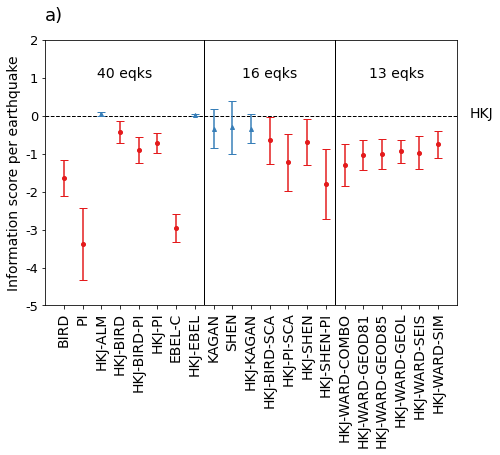

In [105]:
plt.figure()

ttest_results = [ttest_Bird_HKJ, ttest_PI_HKJ, ttest_HKJ_ALM_HKJ, ttest_HKJ_Bird_HKJ,
                ttest_HKJ_Bird_PI_HKJ, ttest_HKJ_PI_HKJ, ttest_Ebel_HKJ, ttest_HKJ_Ebel_HKJ, 
                ttest_HKJ_Kagan, ttest_HKJ_Shen, ttest_HKJ_HKJ_Kagan, ttest_HKJ_HKJ_Bird_sca, 
                ttest_HKJ_HKJ_PI_sca, ttest_HKJ_HKJ_Shen, ttest_HKJ_HKJ_Shen_PI,
                ttest_HKJ_Ward_combo, ttest_HKJ_Ward_geod81, ttest_HKJ_Ward_geod85,
                ttest_HKJ_Ward_geol, ttest_HKJ_Ward_seis, ttest_HKJ_Ward_sim]

ax_ct = plot_comparison_test(ttest_results, plot_args={'xlabel':'', 
                                                       'ylabel': 'Information score per earthquake'})

a= ax_ct.set_xticklabels(['BIRD','PI', 'HKJ-ALM', 'HKJ-BIRD','HKJ-BIRD-PI','HKJ-PI','EBEL-C',
                      'HKJ-EBEL','KAGAN','SHEN','HKJ-KAGAN','HKJ-BIRD-SCA', 'HKJ-PI-SCA',
                      'HKJ-SHEN','HKJ-SHEN-PI','HKJ-WARD-COMBO','HKJ-WARD-GEOD81',
                      'HKJ-WARD-GEOD85','HKJ-WARD-GEOL','HKJ-WARD-SEIS','HKJ-WARD-SIM'],
                      rotation = 90, horizontalalignment='center')

ax_ct.yaxis.tick_left()
ax_ct.yaxis.set_label_position("left")
ax_ct.set_title('')
ax_ct.set_ylim(-5,2)
ax_ct.axline((7.5, 3), (7.5, 1), color='black', linewidth=1)
ax_ct.axline((14.5, 3), (14.5, 1), color='black', linewidth=1)
ax_ct.text(21.7, -0.05, 'HKJ', fontsize=14)
ax_ct.text(1.8, 1, f'{catalog_Cali2.get_number_of_events()} eqks', fontsize=14)
ax_ct.text(9.5, 1, f'{catalog_Shen.get_number_of_events()} eqks', fontsize=14)
ax_ct.text(16.3, 1, f'{catalog_Ward.get_number_of_events()} eqks', fontsize=14)
ax_ct.text(-1., 2.5, 'a)', fontsize =18, color='black')
plt.savefig('Fig10a.png', dpi=300, bbox_inches = 'tight')

#### Binary T-test:

In [106]:
def _t_test_ndarray_bi(target_event_rates1, target_event_rates2, n_obs, n_f1, n_f2, catalog, alpha=0.05):
    """ Computes T test statistic by comparing two target event rate distributions.

    We compare Forecast from Model 1 and with Forecast of Model 2. Information Gain is computed, which is then employed
    to compute T statistic. Confidence interval of Information Gain can be computed using T_critical. For a complete explanation
    see Rhoades, D. A., et al., (2011). Efficient testing of earthquake forecasting models. Acta Geophysica, 59(4), 728-747.
    doi:10.2478/s11600-011-0013-5

    Args:
        target_event_rates1 (numpy.ndarray): nd-array storing target event rates
        target_event_rates2 (numpy.ndarray): nd-array storing target event rates
        n_obs (float, int, numpy.ndarray): number of observed earthquakes, should be whole number and >= zero.
        alpha (float): tolerance level for the type-i error rate of the statistical test

    Returns:
        out (dict): relevant statistics from the t-test

    """
    # Some Pre Calculations -  Because they are being used repeatedly.
    N_p = n_obs  # Total number of observed earthquakes
    N = len(np.unique(np.nonzero(catalog.spatial_magnitude_counts().ravel()))) 
    N1 = n_f1  # Total number of forecasted earthquakes by Model 1
    N2 = n_f2  # Total number of forecasted earthquakes by Model 2
    X1 = numpy.log(target_event_rates1)  # Log of every element of Forecast 1
    X2 = numpy.log(target_event_rates2)  # Log of every element of Forecast 2
    

    # Information Gain, using Equation (17)  of Rhoades et al. 2011
    information_gain = (numpy.sum(X1 - X2) - (N1 - N2)) / N

    # Compute variance of (X1-X2) using Equation (18)  of Rhoades et al. 2011
    first_term = (numpy.sum(numpy.power((X1 - X2), 2))) / (N - 1)
    second_term = numpy.power(numpy.sum(X1 - X2), 2) / (numpy.power(N, 2) - N)
    forecast_variance = first_term - second_term

    forecast_std = numpy.sqrt(forecast_variance)
    t_statistic = information_gain / (forecast_std / numpy.sqrt(N))

    # Obtaining the Critical Value of T from T distribution.
    df = N - 1
    t_critical = scipy.stats.t.ppf(1 - (alpha / 2), df)  # Assuming 2-Tail Distribution  for 2 tail, divide 0.05/2.

    # Computing Information Gain Interval.
    ig_lower = information_gain - (t_critical * forecast_std / numpy.sqrt(N))
    ig_upper = information_gain + (t_critical * forecast_std / numpy.sqrt(N))

    # If T value greater than T critical, Then both Lower and Upper Confidence Interval limits will be greater than Zero.
    # If above Happens, Then It means that Forecasting Model 1 is better than Forecasting Model 2.
    return {'t_statistic': t_statistic,
            't_critical': t_critical,
            'information_gain': information_gain,
            'ig_lower': ig_lower,
            'ig_upper': ig_upper}

In [107]:
def paired_t_test_bi(forecast, benchmark_forecast, observed_catalog, alpha=0.05, scale=False):
    """ Computes the t-test for gridded earthquake forecasts.

    This score is positively oriented, meaning that positive values of the information gain indicate that the
    forecast is performing better than the benchmark forecast.

    Args:
        forecast (csep.core.forecasts.GriddedForecast): nd-array storing gridded rates, axis=-1 should be the magnitude column
        benchmark_forecast (csep.core.forecasts.GriddedForecast): nd-array storing gridded rates, axis=-1 should be the magnitude column
        observed_catalog (csep.core.catalogs.AbstractBaseCatalog): number of observed earthquakes, should be whole number and >= zero.
        alpha (float): tolerance level for the type-i error rate of the statistical test
        scale (bool): if true, scale forecasted rates down to a single day

    Returns:
        evaluation_result: csep.core.evaluations.EvaluationResult
    """

    # needs some pre-processing to put the forecasts in the context that is required for the t-test. this is different
    # for cumulative forecasts (eg, multiple time-horizons) and static file-based forecasts.
    target_event_rate_forecast1p, n_fore1 = forecast.target_event_rates(observed_catalog, scale=scale)
    target_event_rate_forecast2p, n_fore2 = benchmark_forecast.target_event_rates(observed_catalog, scale=scale)
    
    target_event_rate_forecast1 = forecast.data.ravel()[np.unique(np.nonzero(observed_catalog.spatial_magnitude_counts().ravel()))]
    target_event_rate_forecast2 = benchmark_forecast.data.ravel()[np.unique(np.nonzero(observed_catalog.spatial_magnitude_counts().ravel()))]

    # call the primative version operating on ndarray
    out = _t_test_ndarray_bi(target_event_rate_forecast1, target_event_rate_forecast2, observed_catalog.event_count, n_fore1, n_fore2,
                          observed_catalog,
                          alpha=alpha)

    # storing this for later
    result = EvaluationResult()
    result.name = 'Paired T-Test'
    result.test_distribution = (out['ig_lower'], out['ig_upper'])
    result.observed_statistic = out['information_gain']
    result.quantile = (out['t_statistic'], out['t_critical'])
    result.sim_name = (forecast.name, benchmark_forecast.name)
    result.obs_name = observed_catalog.name
    result.status = 'normal'
    result.min_mw = np.min(forecast.magnitudes)
    return result

In [108]:
# Comparative T-tests between earthquake forecasts in California:
ttest_Bird_HKJ = paired_t_test_bi(Bird_f, HKJ_f, catalog_Cali2)
ttest_PI_HKJ = paired_t_test_bi(PI_PIf, HKJ_inPIf, catalog_CaliP2)
ttest_HKJ_ALM_HKJ = paired_t_test_bi(HKJ_ALMf, HKJ_f, catalog_Cali2)
ttest_HKJ_Bird_HKJ = paired_t_test_bi(HKJ_Birdf, HKJ_f, catalog_Cali2)
ttest_HKJ_Bird_PI_HKJ = paired_t_test_bi(HKJ_Bird_PIf, HKJ_f, catalog_Cali2)
ttest_HKJ_PI_HKJ = paired_t_test_bi(HKJ_PIf, HKJ_f, catalog_Cali2) 
ttest_Ebel_HKJ = paired_t_test_bi(Ebel_cf, HKJ_f, catalog_Ebel)
ttest_HKJ_Ebel_HKJ = paired_t_test_bi(HKJ_Ebelf, HKJ_f, catalog_Ebel)

# Comparative T-tests between earthquake forecasts in southern California:
ttest_HKJ_Kagan = paired_t_test_bi(Kagan_f, HKJ_Kaganf_sca, catalog_Kagan) 
ttest_HKJ_Shen = paired_t_test_bi(Shen_f, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_HKJ_Kagan = paired_t_test_bi(HKJ_Kaganf, HKJ_HKJ_Kaganf_sca, catalog_HKJ_Kagan) 
ttest_HKJ_HKJ_Bird_sca = paired_t_test_bi(HKJ_Bird_scaf, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_HKJ_PI_sca = paired_t_test_bi(HKJ_PI_scaf, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_HKJ_Shen = paired_t_test_bi(HKJ_Shenf, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_HKJ_Shen_PI = paired_t_test_bi(HKJ_Shen_PIf, HKJ_Shenf_sca, catalog_Shen)
ttest_HKJ_Ward_combo = paired_t_test_bi(HKJ_Ward_combof, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_geod81 = paired_t_test_bi(HKJ_Ward_geod81f, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_geod85 = paired_t_test_bi(HKJ_Ward_geod85f, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_geol = paired_t_test_bi(HKJ_Ward_geolf, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_seis = paired_t_test_bi(HKJ_Ward_seisf, HKJ_Wardf_sca, catalog_Ward)
ttest_HKJ_Ward_sim = paired_t_test_bi(HKJ_Ward_simf, HKJ_Wardf_sca, catalog_Ward)

/tmp/ipykernel_25787/2265893775.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ok" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(index, result.observed_statistic, 'ok', marker="o", markersize=4, color='#e41a1c') #red
/tmp/ipykernel_25787/2265893775.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  ax.plot(index, result.observed_statistic, 'ok', marker="o", markersize=4, color='#e41a1c') #red
/tmp/ipykernel_25787/2265893775.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ok" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(index, result.observed_statistic, 'ok', marker="o", markersize=4, color='#e41a1c') #red
/tmp/ipykernel_25787/2265893775.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument

Text(-1.0, 2.5, 'b)')

<Figure size 432x288 with 0 Axes>

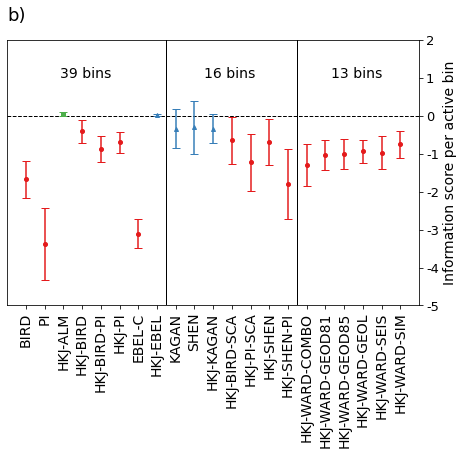

In [109]:
plt.figure()


ttest_results = [ttest_Bird_HKJ, ttest_PI_HKJ, ttest_HKJ_ALM_HKJ, ttest_HKJ_Bird_HKJ,
                ttest_HKJ_Bird_PI_HKJ, ttest_HKJ_PI_HKJ, ttest_Ebel_HKJ, ttest_HKJ_Ebel_HKJ, 
                ttest_HKJ_Kagan, ttest_HKJ_Shen, ttest_HKJ_HKJ_Kagan, ttest_HKJ_HKJ_Bird_sca, 
                ttest_HKJ_HKJ_PI_sca, ttest_HKJ_HKJ_Shen, ttest_HKJ_HKJ_Shen_PI,
                ttest_HKJ_Ward_combo, ttest_HKJ_Ward_geod81, ttest_HKJ_Ward_geod85,
                ttest_HKJ_Ward_geol, ttest_HKJ_Ward_seis, ttest_HKJ_Ward_sim]

ax_ct = plot_comparison_test(ttest_results, plot_args={'xlabel':'', 
                                                       'ylabel': 'Information score per active bin', 
                                                      'title': 'Comparative T-test'})

a= ax_ct.set_xticklabels(['BIRD','PI', 'HKJ-ALM', 'HKJ-BIRD','HKJ-BIRD-PI','HKJ-PI','EBEL-C',
                      'HKJ-EBEL','KAGAN','SHEN','HKJ-KAGAN','HKJ-BIRD-SCA', 'HKJ-PI-SCA',
                      'HKJ-SHEN','HKJ-SHEN-PI','HKJ-WARD-COMBO','HKJ-WARD-GEOD81',
                      'HKJ-WARD-GEOD85','HKJ-WARD-GEOL','HKJ-WARD-SEIS','HKJ-WARD-SIM'],
                      rotation = 90, horizontalalignment='center')

ax_ct.yaxis.tick_right()
ax_ct.yaxis.set_label_position("right")
ax_ct.set_title('')
ax_ct.set_ylim(-5,2)
ax_ct.axline((7.5, 3), (7.5, 1), color='black', linewidth=1)
ax_ct.axline((14.5, 3), (14.5, 1), color='black', linewidth=1)
ax_ct.text(1.8, 1, f'{len(np.unique(np.nonzero(catalog_Cali2.spatial_magnitude_counts().ravel())))} bins', fontsize=14)
ax_ct.text(9.5, 1, f'{len(np.unique(np.nonzero(catalog_Shen.spatial_magnitude_counts().ravel())))} bins', fontsize=14)
ax_ct.text(16.3, 1, f'{len(np.unique(np.nonzero(catalog_Ward.spatial_magnitude_counts().ravel())))} bins', fontsize=14)
ax_ct.text(-1., 2.5, 'b)', fontsize =18, color='black')
plt.savefig('Fig10b.png', dpi=300, bbox_inches = 'tight')

#### Fig. 10: Comparison of information gains T-test results. Information gains per a) earthqauke and b) active bin are presented as tringles and circles, depending on their relative values to that of the HKJ model: blue triangles debote that the model is statistically as informative as HKJ and red circles indicate that a model is significantly less informative than HKJ.

In [110]:
data_s = pd.DataFrame()
data_s['EQs'] = catalog_Cali2.spatial_counts()
data_s['POLLs'] = POLL_HKJ
data_s['BILLs'] = BILL_HKJ

In [111]:
LL_0 = data_s[data_s['EQs'] == 0.0]
LL_1 = data_s[data_s['EQs'] == 1.0]
LL_2 = data_s[data_s['EQs'] == 2.0]
LL_3 = data_s[data_s['EQs'] == 3.0]
LL_4 = data_s[data_s['EQs'] == 4.0]

In [112]:
jPOLL = sum(data_s.POLLs)
jBILL = sum(data_s.BILLs)

POLLs_sc = [sum(LL_0.POLLs), sum(LL_1.POLLs), sum(LL_2.POLLs), sum(LL_3.POLLs), sum(LL_4.POLLs)]
BILLs_sc = [sum(LL_0.BILLs), sum(LL_1.BILLs), sum(LL_2.BILLs), sum(LL_3.BILLs), sum(LL_4.BILLs)]

per_POLLs = np.zeros(len(POLLs_sc))
per_BILLs = np.zeros(len(BILLs_sc))

for i in range(len(POLLs_sc)):
    per_POLLs[i] = POLLs_sc[i] * (100 /jPOLL)
    per_BILLs[i] = BILLs_sc[i] * (100 /jBILL)

/tmp/ipykernel_25787/1892741421.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=13)
/tmp/ipykernel_25787/1892741421.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y, fontsize=13)


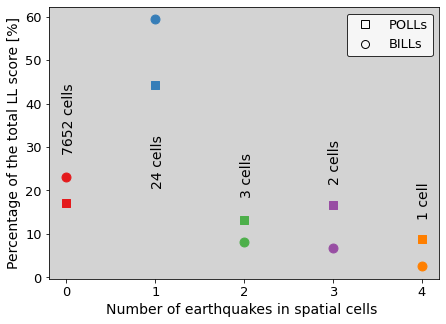

In [113]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_facecolor('lightgrey')
x_p = [0,1,2,3,4]
width = 80
n_cells = [len(LL_0), len(LL_1), len(LL_2), len(LL_3), len(LL_4)]

z_p = ax.scatter(x_p[0], per_POLLs[0], width, c='#e41a1c', marker='s', label='POLLs')
z_b = ax.scatter(x_p[0], per_BILLs[0], width, c = '#e41a1c', label='BILLs')

z_p1 = ax.scatter(x_p[1], per_POLLs[1], width, c='#377eb8', marker='s')
z_b1 = ax.scatter(x_p[1], per_BILLs[1], width, c = '#377eb8')

z_p2 = ax.scatter(x_p[2], per_POLLs[2], width, c='#4daf4a', marker='s')
z_b2 = ax.scatter(x_p[2], per_BILLs[2], width, c = '#4daf4a')

z_p3 = ax.scatter(x_p[3], per_POLLs[3], width, c='#984ea3', marker='s')
z_b3 = ax.scatter(x_p[3], per_BILLs[3], width, c = '#984ea3')

z_p4 = ax.scatter(x_p[4], per_POLLs[4], width, c='#ff7f00', marker='s')
z_b4 = ax.scatter(x_p[4], per_BILLs[4], width, c = '#ff7f00')

ax.set_xlabel('Number of earthquakes in spatial cells ', fontsize = 14)
ax.set_ylabel('Percentage of the total LL score [%]', fontsize = 14)

x=['0', '1', '2', '3', '4']
y = ['','0','10','20','30','40','50','60']

ax.set_xticklabels(x, fontsize=13)
ax.set_yticklabels(y, fontsize=13)
 
a2 =plt.xticks(np.arange(0,5,1))     
ax.legend(fontsize=13)

ax.text(-0.05, 29, f'{len(LL_0)} cells', fontsize=14, rotation=90)
ax.text(0.95, 21, f'{len(LL_1)} cells', fontsize=14, rotation=90)
ax.text(1.95, 19, f'{len(LL_2)} cells', fontsize=14, rotation=90)
ax.text(2.95, 22, f'{len(LL_3)} cells', fontsize=14, rotation=90)
ax.text(3.95, 14, f'{len(LL_4)} cell', fontsize=14, rotation=90)

legend_elements = [Line2D([0], [0], marker='s', color='black', lw=0, label='POLLs', markersize=8, markerfacecolor="None"),
                   Line2D([0], [0], marker='o', color='black', lw=0, label='BILLs', markersize=8, markerfacecolor="None")]
ax.legend(handles=legend_elements, loc=1, fontsize=13, edgecolor='black')

plt.savefig('Fig11.png', dpi=100, bbox_inches = 'tight')

#### Fig. 11: Percentage of the observed joint log-likelihood score obtained by the HKJ model that is due to the occurrence of zero (red), one (blue), two (green), three (purple) and four (orange) events in single spatial cells. We represent POLLs and BILLs with squares and circles, respectively.